Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
num_days_R_prediction=14

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=0 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
241                           NaN             Timor-Leste  -8.874217   
242                           NaN                    Togo   8.619500   
243                           NaN     Trinidad and Tobago  10.691800   
244                           NaN                 Tunisia  33.886917   
245                           NaN                  Turkey  38.963700   
246                           NaN           United States  40.000000   
247                           NaN                  Uganda   1.373333   
248                           NaN                 Ukraine  48.379400   
249                           NaN    United Arab Emirates  23.424076   
250                      Anguilla          United Kingdom  18.220600   
251                       Bermuda          United Kingdom  32.307800   
252        British Virgin Islands          United Kingdom  18.420700   
253                Cayman Islands          United Kingdom  19.313300   
254               Channel Islands          United Kingdom  49.372300   
255   Falkland Islands (Malvinas)          United Kingdom -51.796300   
256                     Gibraltar          United Kingdom  36.140800   
257                   Isle of Man          United Kingdom  54.236100   
258                    Montserrat          United Kingdom  16.742498   
259      Turks and Caicos Islands          United Kingdom  21.694000   
260                           NaN          United Kingdom  55.378100   
261                           NaN                 Uruguay -32.522800   
262                           NaN              Uzbekistan  41.377491   
263                           NaN                 Vanuatu -15.376700   
264                           NaN               Venezuela  

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
247                           NaN             Timor-Leste  -8.874217   
248                           NaN                    Togo   8.619500   
249                           NaN     Trinidad and Tobago  10.691800   
250                           NaN                 Tunisia  33.886917   
251                           NaN                  Turkey  38.963700   
252                           NaN           United States  40.000000   
253                           NaN                  Uganda   1.373333   
254                           NaN                 Ukraine  48.379400   
255                           NaN    United Arab Emirates  23.424076   
256                      Anguilla          United Kingdom  18.220600   
257                       Bermuda          United Kingdom  32.307800   
258        British Virgin Islands          United Kingdom  18.420700   
259                Cayman Islands          United Kingdom  19.313300   
260               Channel Islands          United Kingdom  49.372300   
261   Falkland Islands (Malvinas)          United Kingdom -51.796300   
262                     Gibraltar          United Kingdom  36.140800   
263                   Isle of Man          United Kingdom  54.236100   
264                    Montserrat          United Kingdom  16.742498   
265      Turks and Caicos Islands          United Kingdom  21.694000   
266                           NaN          United Kingdom  55.378100   
267                           NaN                 Uruguay -32.522800   
268                           NaN              Uzbekistan  41.377491   
269                           NaN                 Vanuatu -15.376700   
270                           NaN               Venezuela  

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN      Mauritius -20.348404   57.552152        0        0   
186            NaN         Mexico  23.634500 -102.552800        0        0   
187            NaN        Moldova  47.411600   28.369900        0        0   
188            NaN         Monaco  43.733300    7.416700        0        0   
189            NaN       Mongolia  46.862500  103.846700        0        0   
190            NaN     Montenegro  42.708678   19.374390        0        0   
191            NaN        Morocco  31.791700   -7.092600        0        0   
192            NaN     Mozambique -18.665695   35.529562        0        0   
193            NaN        Namibia -22.957600   18.490400        0        0   
194            NaN          Nepal  28.166700   84.250000        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  11/19/20  11/20/20  11/21/20  \
185        0        0        0        0  ...        10        10        10   
186        0        0        0        0  ...    100104    100823    101373   
187        0        0        0        0  ...      2091      2111      2130   
188        0        0        0        0  ...         3         3         3   
189        0        0        0        0  ...         0         0         0   
190        0        0        0        0  ...       420       429       434   
191        0        0        0        0  ...      5090      5182      5256   
192        0        0        0        0  ...       120       121       123   
193        0        0        0        0  ...       141       143       145   
194        0        0        0        0  ...      1276      1298      1305   

     11/22/20  11/23/20  11/24/20  11/25/20  11/26/20   Population   \
185        10        10        10        10        10           NaN   
186    101676    101926    102739    103597    104242   128,640,794   
187      2149      2169      2188      2209      2229     4,035,942   
188         3         3         3         3         3        39,183   
189         0         0         0         0         0           NaN   
190       439       444       450       459       469       622 500   
191      5316      5396      5469      5539      5619    36,817,128   
192       124       126       127       128       128    31,542,919   
193       145       145       145       145       147           NaN   
194      1321      1337      1361      1389      1412    29,300,000   

             region  
185   Mauritius_nan  
186      Mexico_nan  
187     Moldova_nan  
188      Monaco_nan  
189    Mongolia_nan  
190  Montenegro_nan  
191     Morocco_nan  
192  Mozambique_nan  
193     Namibia_nan  
194       Nepal_nan  

[10 rows x 316 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat        Long  \
175                               NaN     Mozambique -18.665700   35.529600   
176                               NaN        Namibia -22.957600   18.490400   
177                               NaN          Nepal  28.166700   84.250000   
178                             Aruba    Netherlands  12.521100  -69.968300   
179  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
180                           Curacao    Netherlands  12.169600  -68.990000   
181                      Sint Maarten    Netherlands  18.042500  -63.054800   
182                               NaN    Netherlands  52.132600    5.291300   
183                               NaN    New Zealand -40.900600  174.886000   
184                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/19/20  \
175        0        0        0        0        0        0  ...     12849   
176        0        0        0        0        0        0  ...     13182   
177        0        0        0        0        0        0  ...    185638   
178        0        0        0        0        0        0  ...      4569   
179        0        0        0        0        0        0  ...       151   
180        0        0        0        0        0        0  ...       968   
181        0        0        0        0        0        0  ...       878   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...      1948   
184        0        0        0        0        0        0  ...      4225   

     11/20/20  11/21/20  11/22/20  11/23/20  11/24/20  11/25/20  11/26/20  \
175     13053     13151     13151     13229     13408     13459     13520   
176     13191     13209     13225     13234     13272     13339     13355   
177    191002    193325    199024    202067    204858    207998    209435   
178      4580      4588      4596      4607      4618      4632      4640   
179       152       152       152       155       155       155       155   
180       977       988      1004      1031      1043      1057      1078   
181       883       890       890       900       906       919       928   
182         0         0         0         0         0         0         0   
183      1952      1953      1953      1953      1955      1955      1956   
184      4225      4225      4225      4225      4225      4225      4225   

      Population                                         region  
175    31,542,919                                Mozambique_nan  
176           NaN                                   Namibia_nan  
177    29,300,000                                     Nepal_nan  
178           NaN                             Netherlands_Aruba  
179           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
180           NaN                           Netherlands_Curacao  
181           NaN                      Netherlands_Sint Maarten  
182    17,180,000                               Netherlands_nan  
183     4,813,844                               New Zealand_nan  
184     6,649,701                                 Nicaragua_nan  

[10 rows x 316 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN      Mauritius -20.348404   57.552152        0        0   
186            NaN         Mexico  23.634500 -102.552800        0        0   
187            NaN        Moldova  47.411600   28.369900        0        0   
188            NaN         Monaco  43.733300    7.416700        0        0   
189            NaN       Mongolia  46.862500  103.846700        0        0   
190            NaN     Montenegro  42.708678   19.374390        0        0   
191            NaN        Morocco  31.791700   -7.092600        0        0   
192            NaN     Mozambique -18.665695   35.529562        0        0   
193            NaN        Namibia -22.957600   18.490400        0        0   
194            NaN          Nepal  28.166700   84.250000        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  11/19/20  11/20/20  11/21/20  \
185        0        0        0        0  ...       494       494       494   
186        0        0        0        0  ...   1019543   1025969   1032688   
187        0        0        0        0  ...     93961     95383     96689   
188        0        0        0        0  ...       573       577       581   
189        0        0        0        0  ...       555       578       608   
190        0        0        0        0  ...     29577     30079     30653   
191        0        0        0        0  ...    311554    316260    320962   
192        0        0        0        0  ...     14723     14877     14981   
193        0        0        0        0  ...     13662     13712     13811   
194        0        1        1        1  ...    215020    216965    218639   

     11/22/20  11/23/20  11/24/20  11/25/20  11/26/20   Population   \
185       494       494       494       497       498           NaN   
186   1041875   1049358   1060152   1070487   1078594   128,640,794   
187     97941     98418     99633    101203    102894     4,035,942   
188       582       583       587       594       600        39,183   
189       640       672       699       712       738           NaN   
190     31062     31618     32188     32808     33316       622 500   
191    324941    327528    331527    336506    340684    36,817,128   
192     15037     15109     15231     15302     15467    31,542,919   
193     13865     13897     13938     14006     14155           NaN   
194    220308    222288    224078    226026    227640    29,300,000   

             region  
185   Mauritius_nan  
186      Mexico_nan  
187     Moldova_nan  
188      Monaco_nan  
189    Mongolia_nan  
190  Montenegro_nan  
191     Morocco_nan  
192  Mozambique_nan  
193     Namibia_nan  
194       Nepal_nan  

[10 rows x 316 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                       Saint Lucia  13.909400  -60.978900   
221            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
222            NaN                        San Marino  43.942400   12.457800   
223            NaN             Sao Tome and Principe   0.186400    6.613100   
224            NaN                      Saudi Arabia  23.885942   45.079162   
225            NaN                           Senegal  14.497400  -14.452400   
226            NaN                            Serbia  44.016500   21.005900   
227            NaN                        Seychelles  -4.679600   55.492000   
228            NaN                      Sierra Leone   8.460555  -11.779889   
229            NaN                         Singapore   1.283300  103.833300   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/19/20  \
220        0        0        0        0        0        0  ...       203   
221        0        0        0        0        0        0  ...        84   
222        0        0        0        0        0        0  ...      1358   
223        0        0        0        0        0        0  ...       974   
224        0        0        0        0        0        0  ...    354527   
225        0        0        0        0        0        0  ...     15835   
226        0        0        0        0        0        0  ...    104097   
227        0        0        0        0        0        0  ...       163   
228        0        0        0        0        0        0  ...      2397   
229        0        1        3        3        4        5  ...     58139   

     11/20/20  11/21/20  11/22/20  11/23/20  11/24/20  11/25/20  11/26/20  \
220       203       204       220       223       226       235       238   
221        84        84        84        84        84        84        84   
222      1395      1395      1395      1428      1428      1492      1514   
223       974       979       979       981       981       982       985   
224    354813    355034    355258    355489    355741    356067    356389   
225     15848     15865     15882     15897     15908     15927     15960   
226    110351    116125    121120    126187    133029    140608    148214   
227       163       163       163       166       166       166       166   
228      2399      2405      2405      2406      2406      2408      2409   
229     58143     58148     58160     58165     58183     58190     58195   

      Population                                 region  
220           NaN                       Saint Lucia_nan  
221           NaN  Saint Vincent and the Grenadines_nan  
222        33,916                        San Marino_nan  
223           NaN             Sao Tome and Principe_nan  
224    34,695,447                      Saudi Arabia_nan  
225           NaN                           Senegal_nan  
226     8,744,671                            Serbia_nan  
227           NaN                        Seychelles_nan  
228           NaN                      Sierra Leone_nan  
229     5,612,000                         Singapore_nan  

[10 rows x 316 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

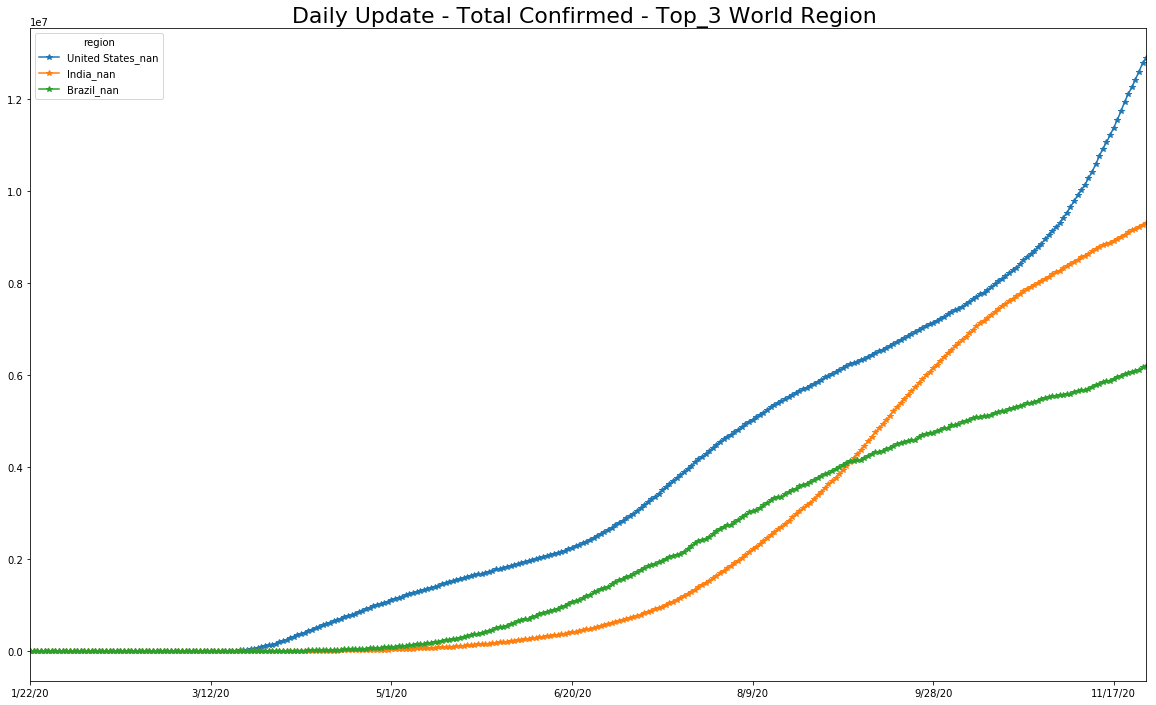

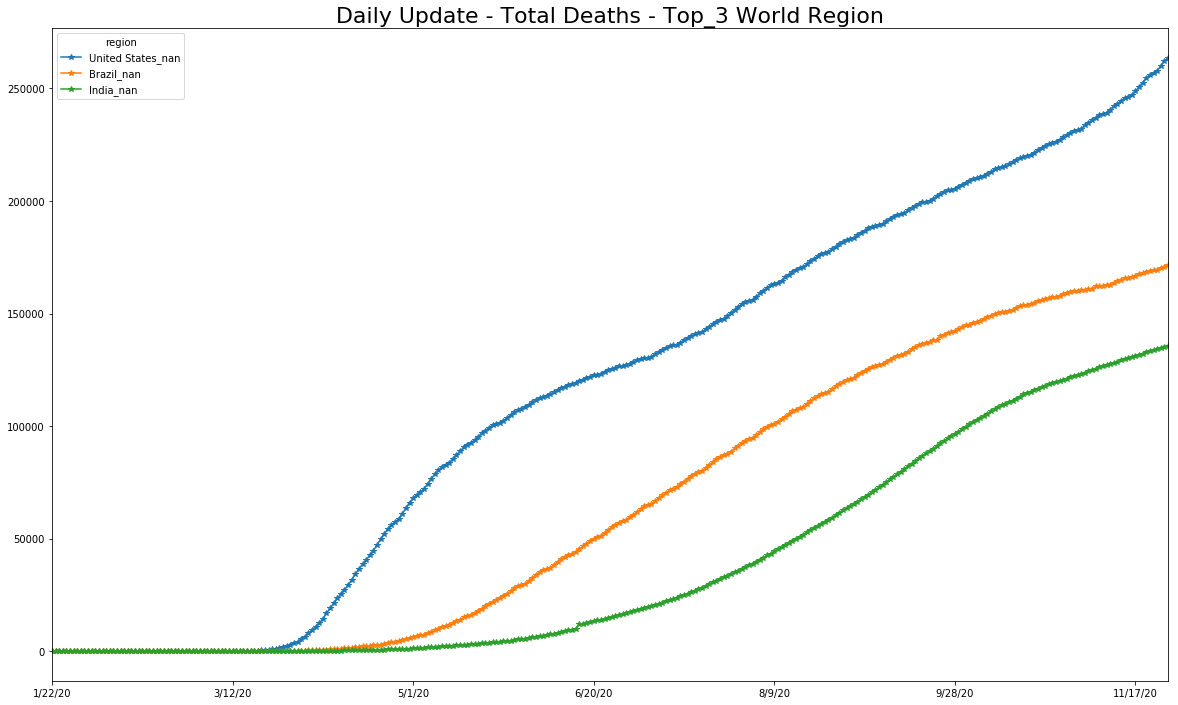

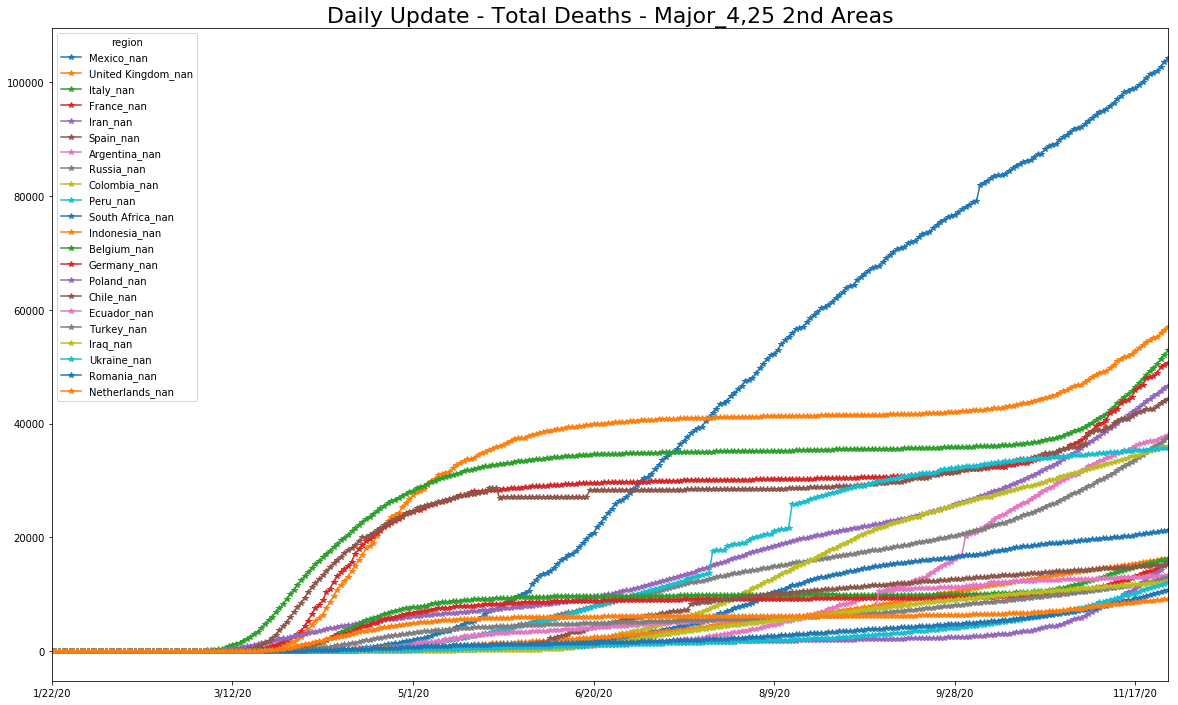

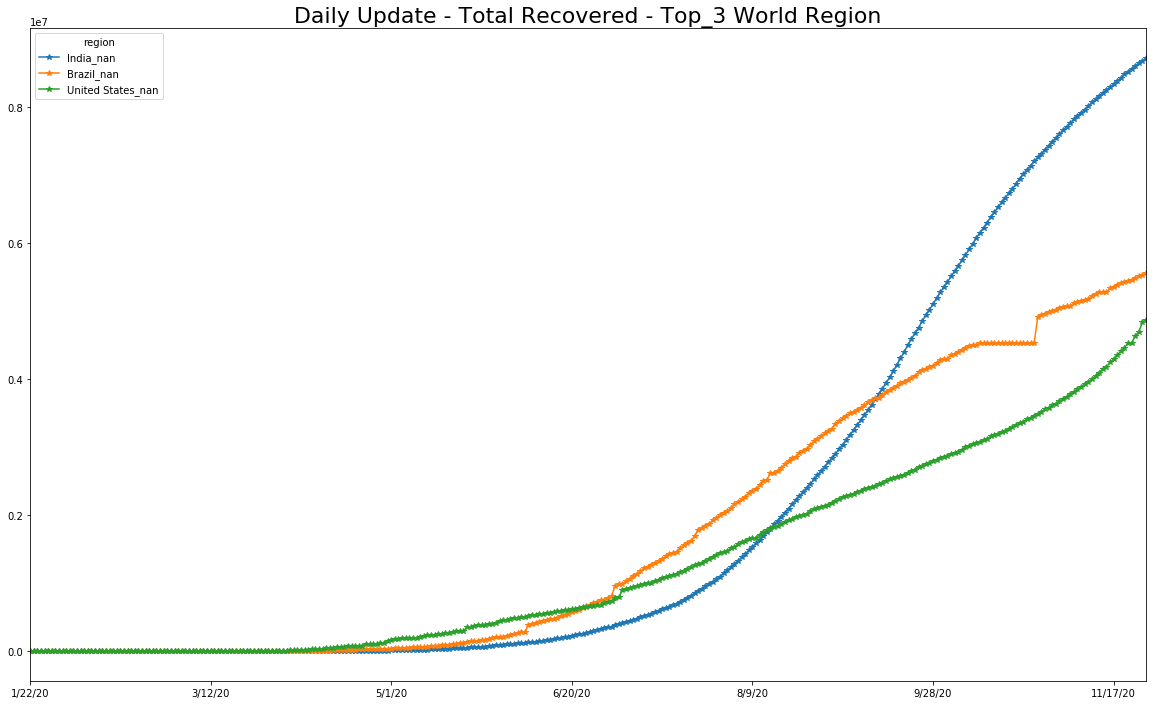

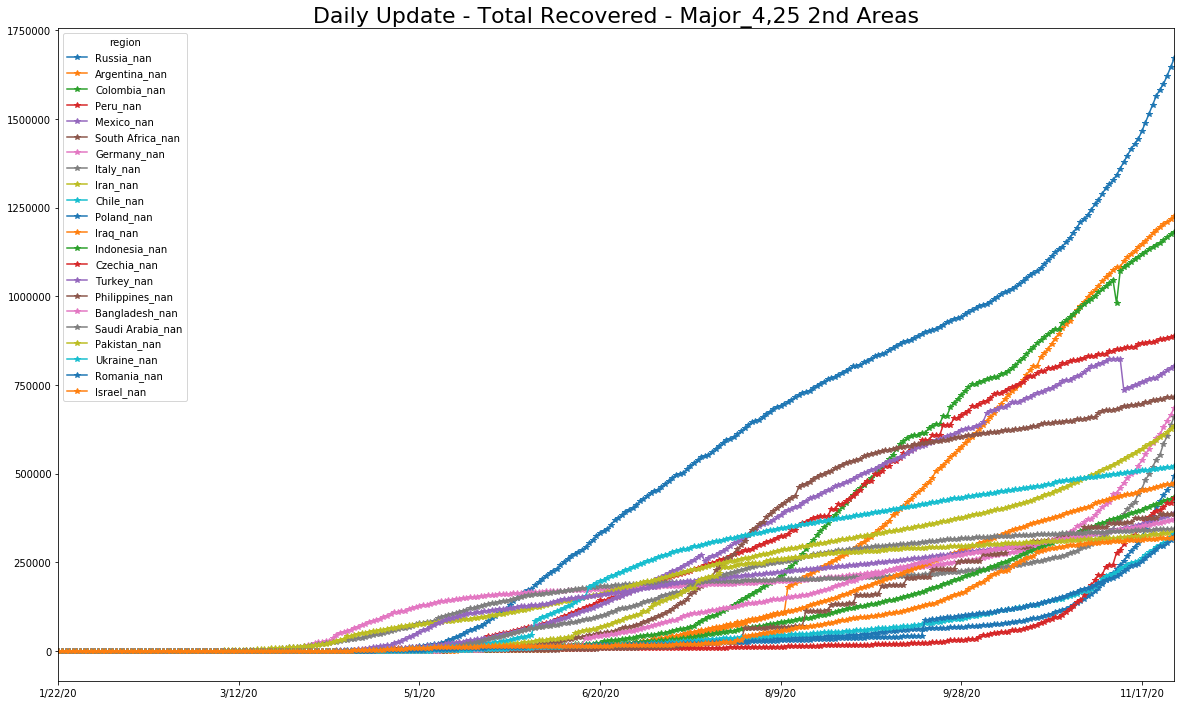

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2020/11/27


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

date                     region   min   max
0   2020/11/28  Australia_New South Wales  18.7  24.7
1   2020/11/28                Austria_nan  -1.1  -0.3
2   2020/11/28                Belgium_nan   7.0   8.2
3   2020/11/28                 Brazil_nan  20.0  21.7
4   2020/11/28             Canada_Ontario   0.0   0.0
5   2020/11/28              Canada_Quebec  -1.7  -1.6
6   2020/11/28                  Chile_nan  12.1  20.0
7   2020/11/28              China_Beijing  -4.0   4.0
8   2020/11/28            China_Guangdong  16.7  22.6
9   2020/11/28            China_Hong Kong  20.6  26.1
10  2020/11/28                China_Hubei   6.0  10.7
11  2020/11/28                China_Macau  20.0  23.8
12  2020/11/28             China_Shanghai  11.8  12.9
13  2020/11/28                Finland_nan  -1.0  -0.2
14  2020/11/28                 France_nan   7.1   8.0
15  2020/11/28                Germany_nan  -2.0   0.7
16  2020/11/28                  India_nan  18.6  22.6
17  2020/11/28                   Iran_nan   6.0  14.0
18  2020/11/28                  Italy_nan   7.2   8.8
19  2020/11/28                  Japan_nan   2.2   6.7
20  2020/11/28           Korea, South_nan   3.2  11.0
21  2020/11/28               Malaysia_nan  21.2  27.0
22  2020/11/28                 Mexico_nan  15.1  15.1
23  2020/11/28            Netherlands_nan  10.0  11.1
24  2020/11/28                 Norway_nan  -6.1  -3.9
25  2020/11/28                   Peru_nan  23.7  24.2
26  2020/11/28            Philippines_nan  22.8  28.9
27  2020/11/28                 Poland_nan   3.3   3.9
28  2020/11/28               Portugal_nan   8.2   9.6
29  2020/11/28                 Russia_nan -15.0 -12.0
30  2020/11/28              Singapore_nan  25.5  29.0
31  2020/11/28                  Spain_nan   8.8   9.9
32  2020/11/28                 Sweden_nan   2.2   3.3
33  2020/11/28            Switzerland_nan   0.6   0.9
34  2020/11/28                 Turkey_nan  -5.3  -2.0
35  2020/11/28          United States_nan  -3.0  -3.0
36  2020/11/28         United Kingdom_nan   5.0   5.6

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34994         3752        20770          862         576   
7/16/20            35070         3851        21355          877         607   
7/17/20            35229         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  \
7/15/20  ...         1009           14581            0          10428   
7/16/20  ...         1026           15066            0          10854   
7/17/20  ...         1037           15607            0          11191   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
7/15/20          381                    7064                  10       1526   
7/16/20          381                    7412                  10       1552   
7/17/20          382                    7764                  10       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 271 columns]

In [24]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/23/20            44988        33556        75867         6304       14634   
11/24/20            45280        34300        77000         6351       14742   
11/25/20            45490        34944        78025         6428       14821   
11/26/20            45716        35600        79110         6534       14920   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/23/20                      139        1374631       126709   
11/24/20                      139        1381795       127522   
11/25/20                      140        1390388       129085   
11/26/20                      141        1399431       130870   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
11/23/20                                     115                       4548   
11/24/20                                     115                       4552   
11/25/20                                     115                       4552   
11/26/20                                     116                       4556   

region    ...  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  \
11/23/20  ...         4763           71774            1         100143   
11/24/20  ...         4870           71985            1         100498   
11/25/20  ...         4988           72227            1         100817   
11/26/20  ...         5117           72409            1         101215   

region    Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
11/23/20         1312                   73196                  10       2107   
11/24/20         1316                   75007                  10       2114   
11/25/20         1321                   76727                  10       2124   
11/26/20         1331                   78493                  10       2137   

region    Zambia_nan  Zimbabwe_nan  
11/23/20       17454          9308  
11/24/20       17466          9398  
11/25/20       17535          9508  
11/26/20       17553          9623  

[4 rows x 271 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
7787 2020-05-10  Vietnam_nan  26.9  33.0
7788 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35070             0             0   
2     2020-07-17  Afghanistan_nan      35229            76             0   
3     2020-07-18  Afghanistan_nan      35301           159             0   
4     2020-07-19  Afghanistan_nan      35475            72           307   
5     2020-07-20  Afghanistan_nan      35526           174           405   
6     2020-07-21  Afghanistan_nan      35615            51           297   
7     2020-07-22  Afghanistan_nan      35727            89           314   
8     2020-07-23  Afghanistan_nan      35928           112           252   
9     2020-07-24  Afghanistan_nan      35981           201           402   
10    2020-07-25  Afghanistan_nan      36036            53           366   
11    2020-07-26  Afghanistan_nan      36157            55           309   
12    2020-07-27  Afghanistan_nan      36263           121           229   
13    2020-07-28  Afghanistan_nan      36368           106           282   
14    2020-07-29  Afghanistan_nan      36471           105           332   
15    2020-07-30  Afghanistan_nan      36542           103           314   
16    2020-07-31  Afghanistan_nan      36675            71           279   
17    2020-08-01  Afghanistan_nan      36710           133           307   
18    2020-08-02  Afghanistan_nan      36710            35           239   
19    2020-08-03  Afghanistan_nan      36747             0           168   
20    2020-08-04  Afghanistan_nan      36782            37            72   
21    2020-08-05  Afghanistan_nan      36829            35            72   
22    2020-08-06  Afghanistan_nan      36896            47           119   
23    2020-08-07  Afghanistan_nan      37015            67           149   
24    2020-08-08  Afghanistan_nan      37054           119           233   
25    2020-08-09  Afghanistan_nan      37054            39           225   
26    2020-08-10  Afghanistan_nan      37162             0           158   
27    2020-08-11  Afghanistan_nan      37269           108           147   
28    2020-08-12  Afghanistan_nan      37345           107           215   
29    2020-08-13  Afghanistan_nan      37424            76           291   
30    2020-08-14  Afghanistan_nan      37431            79           262   
...          ...              ...        ...           ...           ...   
37642 2020-10-29     Zimbabwe_nan       8349             5            44   
37643 2020-10-30     Zimbabwe_nan       8362            29            46   
37644 2020-10-31     Zimbabwe_nan       8367            13            47   
37645 2020-11-01     Zimbabwe_nan       8374             5            47   
37646 2020-11-02     Zimbabwe_nan       8389             7            25   
37647 2020-11-03     Zimbabwe_nan       8410            15            27   
37648 2020-11-04     Zimbabwe_nan       8427            21            43   
37649 2020-11-05     Zimbabwe_nan       8444            17            53   
37650 2020-11-06     Zimbabwe_nan       8471            17            55   
37651 2020-11-07     Zimbabwe_nan       8498            27            61   
37652 2020-11-08     Zimbabwe_nan       8531            27            71   
37653 2020-11-09     Zimbabwe_nan       8561            33            87   
37654 2020-11-10     Zimbabwe_nan       8610            30            90   
37655 2020-11-11     Zimbabwe_nan       8667            49           112   
37656 2020-11-12     Zimbabwe_nan       8696            57           136   
37657 2020-11-13     Zimbabwe_nan       8765            29           135   
37658 2020-11-14     Zimbabwe_nan       8786            69           155   
37659 2020-11-15     Zimbabwe_nan       8829            21           119   
37660 2020-11-16     Zimbabwe_nan       8897            43           133   
37661 2020-11-17     Zimbabwe_nan       8945            68           132   
37662 2020-11-18     Zimbabwe_nan       8981            48  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
37671 2020-11-27  Zimbabwe_nan          0           115           315   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
37671           577         101.209613         103.384293          106.37862   

       last_day  kalman_prediction  population  infected_rate  min  max  
37671      9623             9673.0    14862924       0.000006  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
37671 2020-11-27  Zimbabwe_nan          0           115           315   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
37671           577         101.209613         103.384293          106.37862   

       last_day  kalman_prediction  population  infected_rate  min  max  
37671      9623             9673.0    14862924       0.000006  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
36853  2020-11-25  Zimbabwe_nan       9508            90           226   
36854  2020-11-26  Zimbabwe_nan       9623           110           288   
36855  2020-11-27  Zimbabwe_nan          0           115           315   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
36853           453         100.967018         102.464130         105.064394   
36854           527         101.170568         103.123753         105.868055   
36855           577         101.209613         103.384293         106.378620   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
36853                 9398  ...    14862924       0.000006  NaN  NaN   
36854                 9508  ...    14862924       0.000006  NaN  NaN   
36855                 9623  ...    14862924       0.000006  NaN  NaN   

       population_percentage : infected_rate confirmed  \
36853                                         0.000632   
36854                                         0.000640   
36855                                         0.000648   

       population_percentage : factor 9/10 infected_rate confirmed  \
36853                                           0.006324             
36854                                           0.006398             
36855                                           0.006475             

       delta : new_cases  delta : new_cases per 1M hab  \
36853               44.0                      2.960387   
36854               42.0                      2.825824   
36855               50.0                      3.364076   

       delta : roling 7day AVG  \
36853                64.714286   
36854                75.285714   
36855                82.428571   

       delta : aprox 14-day case notification rate per 100k hab  
36853                                           6.095705         
36854                                           7.091471         
36855                                           7.764286         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
260  United States_nan  1.269225e+12  1.126599e+06  114614.088889


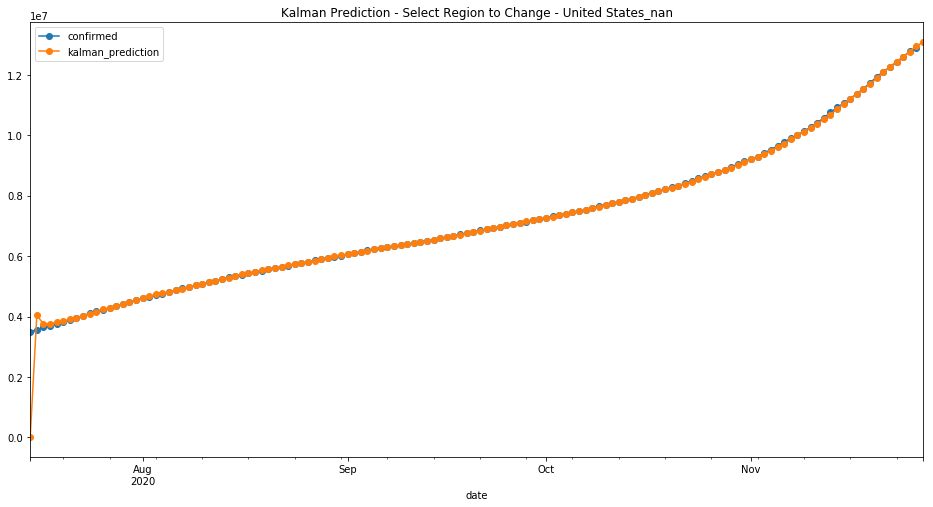

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
211  Russia_nan  3.573191e+10  189028.858546  18558.207407


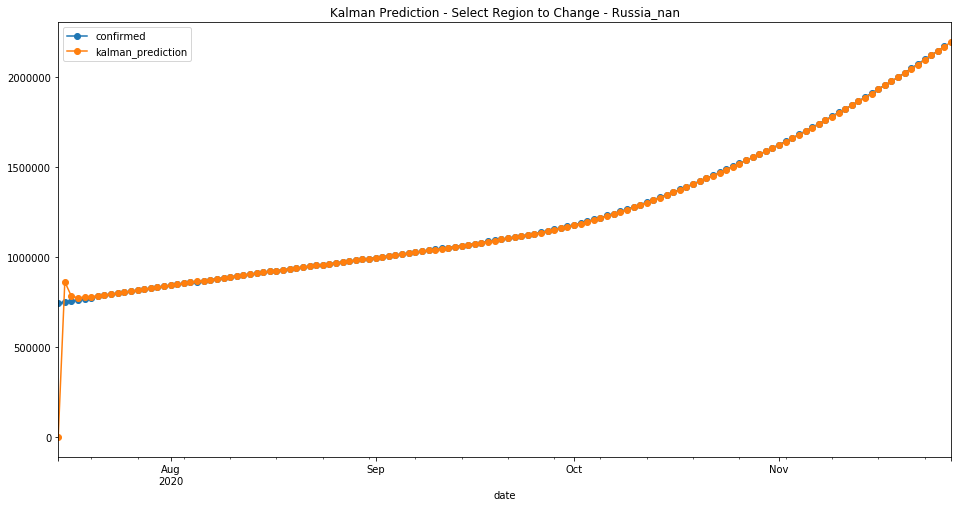

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse           mae
30  Brazil_nan  2.881652e+11  536810.233342  63370.251852


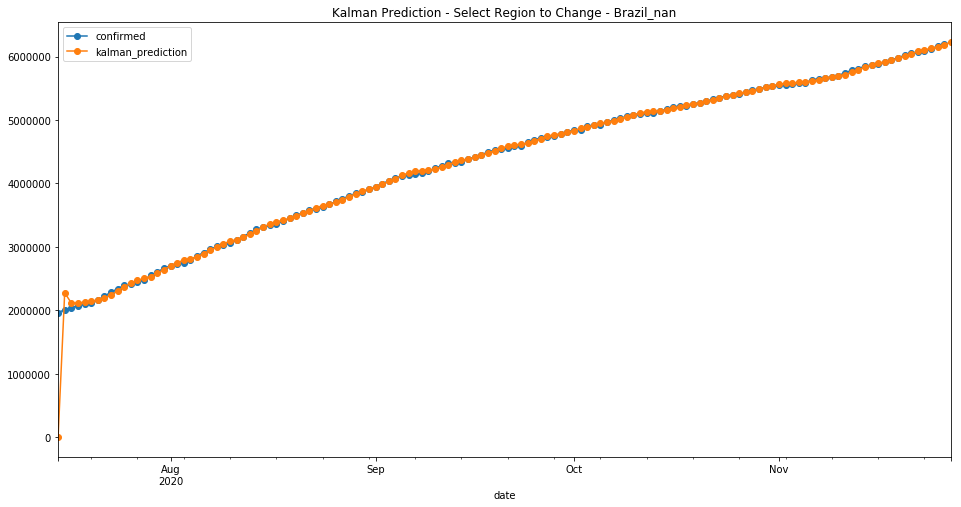

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
259  United Kingdom_nan  1.880597e+10  137134.851878  14474.592593


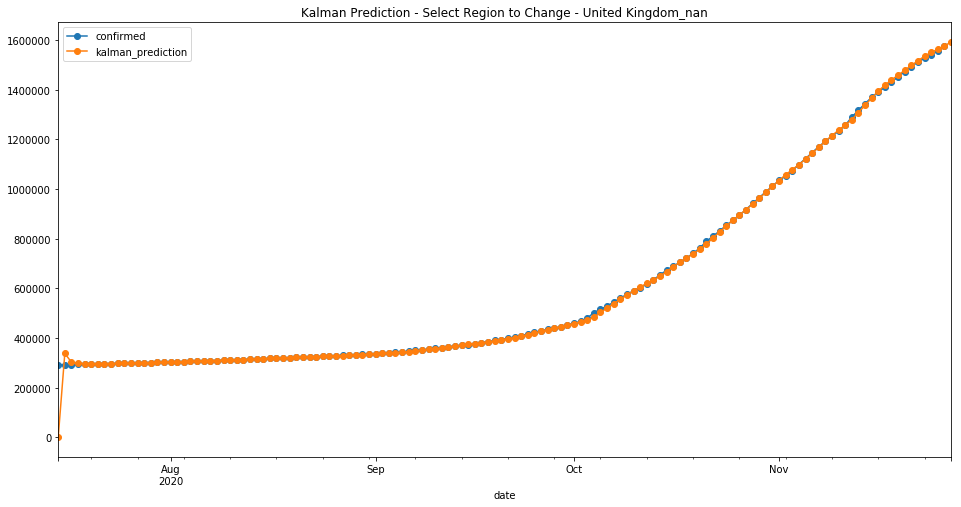

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmple0kc0lt
  JVM stdout: /tmp/tmple0kc0lt/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmple0kc0lt/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    1 month and 29 days
H2O_cluster_name:           H2O_from_python_unknownUser_52jaea
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-11-19
last_train_date= 2020-11-26
first_bootstrap_date= 2020-11-18
boost_bootstrap_date= 2020-11-23
first_test_date= 2020-11-17
last_test_date= 2020-11-27
first_valid_date= 2020-11-25


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   43844.0      43851 2020-11-18  Afghanistan_nan
1   44072.0      44228 2020-11-19  Afghanistan_nan
2   44422.0      44443 2020-11-20  Afghanistan_nan
3   44696.0      44503 2020-11-21  Afghanistan_nan
4   44840.0      44706 2020-11-22  Afghanistan_nan
5   45029.0      44988 2020-11-23  Afghanistan_nan
6   45270.0      45280 2020-11-24  Afghanistan_nan
7   45544.0      45490 2020-11-25  Afghanistan_nan
8   45780.0      45716 2020-11-26  Afghanistan_nan
9   46019.0          0 2020-11-27  Afghanistan_nan
10  29513.0      29837 2020-11-18      Albania_nan
11  30244.0      30623 2020-11-19      Albania_nan
12  31045.0      31459 2020-11-20      Albania_nan
13  31912.0      32196 2020-11-21      Albania_nan
14  32744.0      32761 2020-11-22      Albania_nan
15  33433.0      33556 2020-11-23      Albania_nan
16  34184.0      34300 2020-11-24      Albania_nan
17  34937.0      34944 2020-11-25      Albania_nan
18  35621.0      35600 2020-11-26      Albania_nan
19  36276.0          0 2020-11-27      Albania_nan
20  70452.0      70629 2020-11-18      Algeria_nan
21  71509.0      71652 2020-11-19      Algeria_nan
22  72573.0      72755 2020-11-20      Algeria_nan
23  73707.0      73774 2020-11-21      Algeria_nan
24  74781.0      74862 2020-11-22      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175   95238.0      95281 2020-11-23  Azerbaijan_nan
176   97804.0      98927 2020-11-24  Azerbaijan_nan
177  101505.0     102396 2020-11-25  Azerbaijan_nan
178  105030.0     106101 2020-11-26  Azerbaijan_nan
179  108864.0          0 2020-11-27  Azerbaijan_nan
180    7403.0       7323 2020-11-18     Bahamas_nan
181    7487.0       7348 2020-11-19     Bahamas_nan
182    7490.0       7367 2020-11-20     Bahamas_nan
183    7512.0       7395 2020-11-21     Bahamas_nan
184    7525.0       7413 2020-11-22     Bahamas_nan
185    7553.0       7431 2020-11-23     Bahamas_nan
186    7566.0       7460 2020-11-24     Bahamas_nan
187    7574.0       7469 2020-11-25     Bahamas_nan
188    7608.0       7482 2020-11-26     Bahamas_nan
189    7614.0          0 2020-11-27     Bahamas_nan
190   84771.0      85182 2020-11-18     Bahrain_nan
191   84937.0      85317 2020-11-19     Bahrain_nan
192   85068.0      85467 2020-11-20     Bahrain_nan
193   85211.0      85591 2020-11-21     Bahrain_nan
194   85332.0      85705 2020-11-22     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220  117814.0     118008 2020-11-18  Belarus_nan
221  119168.0     119390 2020-11-19  Belarus_nan
222  120575.0     120847 2020-11-20  Belarus_nan
223  122051.0     122435 2020-11-21  Belarus_nan
224  123658.0     123999 2020-11-22  Belarus_nan
225  125268.0     125482 2020-11-23  Belarus_nan
226  126827.0     126953 2020-11-24  Belarus_nan
227  128366.0     128449 2020-11-25  Belarus_nan
228  129901.0     130012 2020-11-26  Belarus_nan
229  131474.0          0 2020-11-27  Belarus_nan
230  545686.0     545787 2020-11-18  Belgium_nan
231  550243.0     550264 2020-11-19  Belgium_nan
232  553957.0     553680 2020-11-20  Belgium_nan
233  557242.0     556904 2020-11-21  Belgium_nan
234  560569.0     558779 2020-11-22  Belgium_nan
235  562509.0     559902 2020-11-23  Belgium_nan
236  563547.0     561803 2020-11-24  Belgium_nan
237  565028.0     564967 2020-11-25  Belgium_nan
238  567509.0     567532 2020-11-26  Belgium_nan
239  569570.0          0 2020-11-27  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  2280149061.6591597
# MSE on the validation data =  2629164954211.07
# R^2 on the training data =  0.999272534844986
# R^2 on the validation data =  0.46603685067167633


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1606456968496_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           17699548.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       21.0       23.0      22.958      2454.0      2883.0     2768.604



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2280149061.6591597
RMSE: 47750.9063962053
MAE: 4281.693074233497
RMSLE: 0.2026053778592873
Mean Residual Deviance: 2280149061.6591597

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 2629164954211.07
RMSE: 1621469.997937387
MAE: 418538.92957204464
RMSLE: 7.14266137115161
Mean Residual Deviance: 2629164954211.07

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-11-27 06:02:58   0.095 sec              0.0            NaN   
1     2020-11-27 06:02:58   0.567 sec              1.0   63859.969393   
2     2020-11-27 06:02:58   0.773 sec              2.0   86716.856133   
3     2020-11-27 06:02:59   0.912 sec              3.0   78039.219937   
4     2020-11-27 06:02:59   1.027 sec              4.0   75141.983097   
5     2020-11-27 06:02:59   1.145 sec              5.0   85089.203477   
6     2020-11-27 06:02:59   1.418 sec              6.0   83690.054643   
7     2020-11-27 06:02:59   1.517 sec              7.0   73963.516740   
8     2020-11-27 06:02:59   1.593 sec              8.0   69319.372856   
9     2020-11-27 06:02:59   1.670 sec              9.0   67676.292189   
10    2020-11-27 06:02:59   1.758 sec             10.0   66702.774725   
11    2020-11-27 06:02:59   1.855 sec             11.0   65103.195100   
12    2020-11-27 06:03:00   1.930 sec             12.0   64030.504544   
13    2020-11-27 06:03:00   2.000 sec             13.0   63593.602924   
14    2020-11-27 06:03:00   2.110 sec             14.0   62897.504221   
15    2020-11-27 06:03:00   2.257 sec             15.0   61111.971878   
16    2020-11-27 06:03:00   2.383 sec             16.0   60845.176550   
17    2020-11-27 06:03:00   2.541 sec             17.0   59868.688320   
18    2020-11-27 06:03:00   2.688 sec             18.0   59690.945795   
19    2020-11-27 06:03:00   2.858 sec             19.0   59502.209475   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   13610.816610       4.078096e+09     1.569094e+06   407505.033573   
2   13799.510894       7.519813e+09     1.619668e+06   421422.147910   
3   12870.281935       6.090120e+09     1.633381e+06   422331.397710   
4   11931.208901       5.646318e+09     1.588998e+06   415054.414098   
5   12398.476003       7.240173e+09     1.596261e+06   416481.612007   
6   12219.593357       7.004025e+09     1.602231e+06   416917.987061   
7   11070.495484       5.470602e+09     1.611647e+06   419016.743877   
8   10475.251666       4.805175e+09     1.618045e+06   419558.869053   
9   10068.742991       4.580081e+09     1.612986e+06   419140.883122   
10   9584.008866       4.449260e+09     1.616941e+06   420183.107831   
11   9133.106447       4.238426e+09     1.618639e+06   419912.775079   
12   8730.084753       4.099906e+09     1.615911e+06   419128.121501   
13   8697.844524       4.044146e+09     1.620069e+06   419572.204553   
14   8421.200228       3.956096e+09     1.624993e+06   419643.175202   
15   8362.518787       3.734673e+09     1.620332e+06   419659.401483   
16   8165.398204       3.702136e+09     1.616921e+06   418896.585498   
17   7981.747551       3.584260e+09     1.606111e+06   417347.882672   
18   7849.706402       3.563009e+09     1.608654e+06   417643.879990   
19   7716.480977       3.540513e+09     1.600297e+06   416358.179584   

    validation_deviance  
0                   NaN  
1          2.462054e+12  
2          2.623325e+12  
3          2.667934e+12  
4          2.524914e+12  
5          2.548048e+12  
6          2.567144e+12  
7          2.597406e+12  
8          2.618071e+12  
9          2.601725e+12  
10         2.614498e+12  
11         2.619992e+12  
12         2.611167e+12  
13         2.624624e+12  
14         2.640603e+12  
15         2.625476e+12  
16         2.614433e+12  
17         2.579591e+12  
18         2.587767e+12  
19         2.560949e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         2.854257e+18           1.000000    0.364259
1            last_day         2.206658e+18           0.773111    0.281612
2              region         1.164259e+18           0.407903    0.148582
3        7_day_change         6.849683e+17           0.239981    0.087415
4        3_day_change         4.550527e+17           0.159429    0.058074
5        1_day_change         2.972877e+17           0.104156    0.037940
6       infected_rate         6.325787e+16           0.022163    0.008073
7   7_day_change_rate         4.494828e+16           0.015748    0.005736
8   1_day_change_rate         2.784537e+16           0.009756    0.003554
9   3_day_change_rate         2.316355e+16           0.008115    0.002956
10                max         7.257272e+15           0.002543    0.000926
11                min         6.842636e+15           0.002397    0.000873

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         2.854257e+18           1.000000    0.364259
1            last_day         2.206658e+18           0.773111    0.281612
2              region         1.164259e+18           0.407903    0.148582
3        7_day_change         6.849683e+17           0.239981    0.087415
4        3_day_change         4.550527e+17           0.159429    0.058074
5        1_day_change         2.972877e+17           0.104156    0.037940
6       infected_rate         6.325787e+16           0.022163    0.008073
7   7_day_change_rate         4.494828e+16           0.015748    0.005736
8   1_day_change_rate         2.784537e+16           0.009756    0.003554
9   3_day_change_rate         2.316355e+16           0.008115    0.002956
10                max         7.257272e+15           0.002543    0.000926
11                min         6.842636e+15           0.002397    0.000873

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


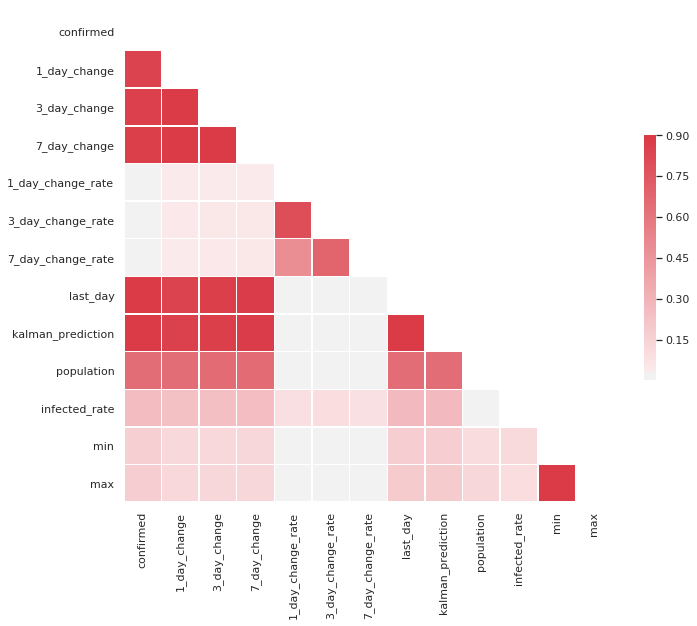

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.850268
3_day_change         0.863707
7_day_change         0.869737
1_day_change_rate    0.027276
3_day_change_rate    0.027870
7_day_change_rate    0.022262
last_day             0.988579
kalman_prediction    0.989175
population           0.648351
infected_rate        0.263980
min                  0.173735
max                  0.181804
Name: confirmed, dtype: float64


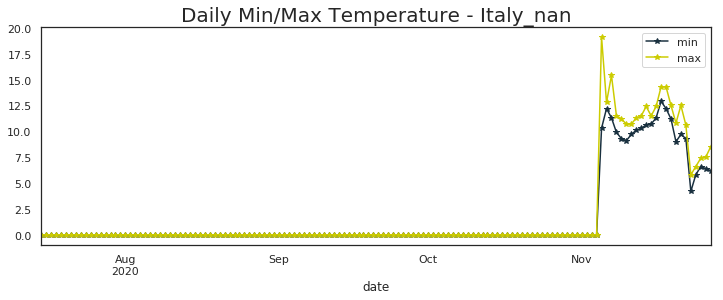

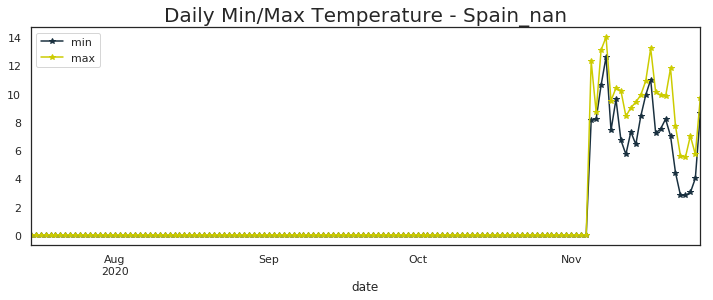

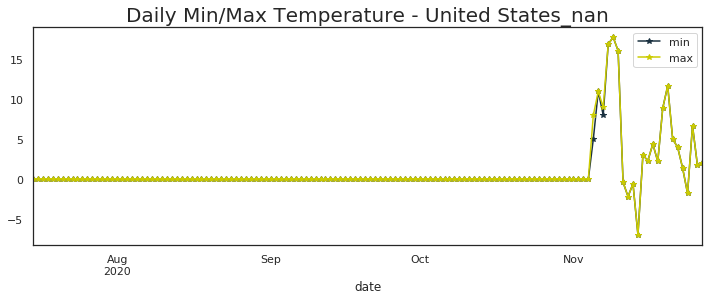

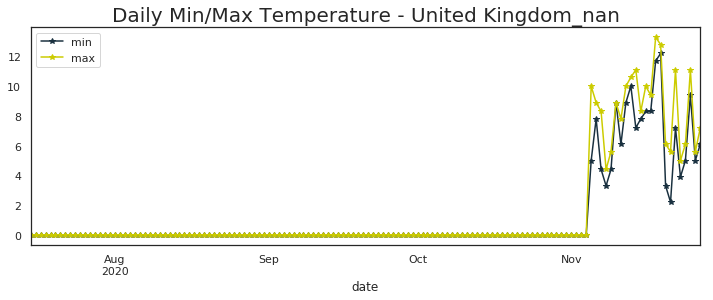

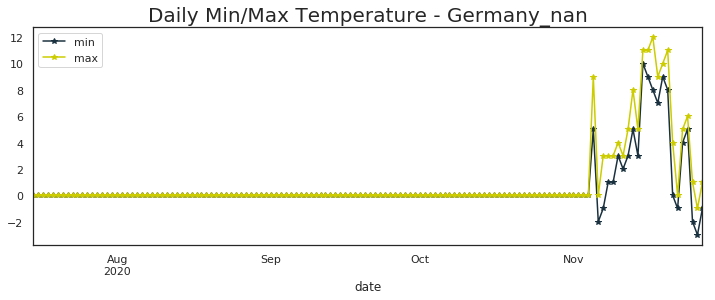

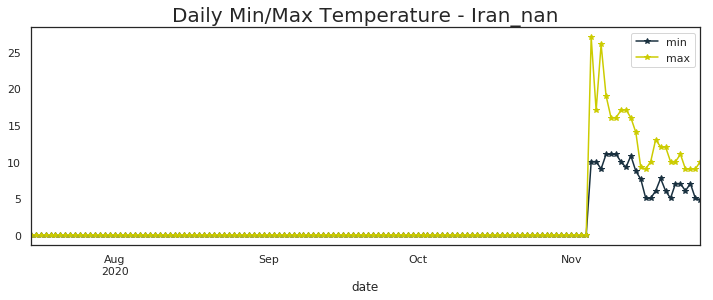

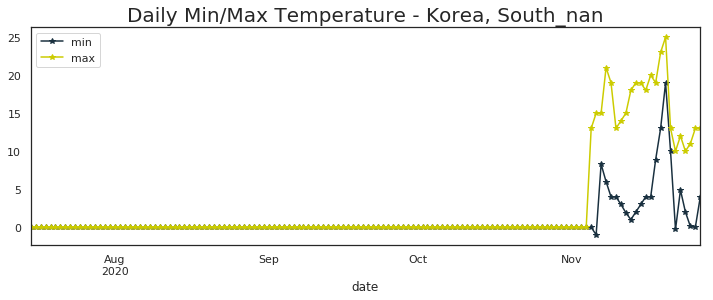

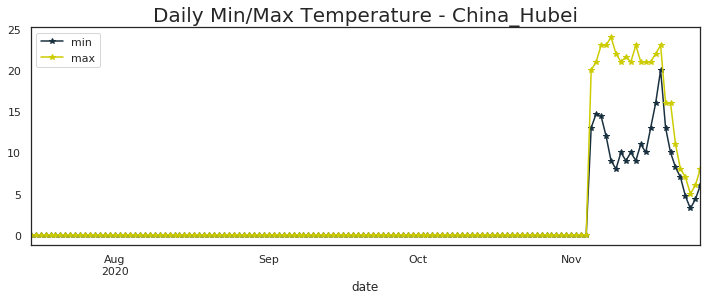

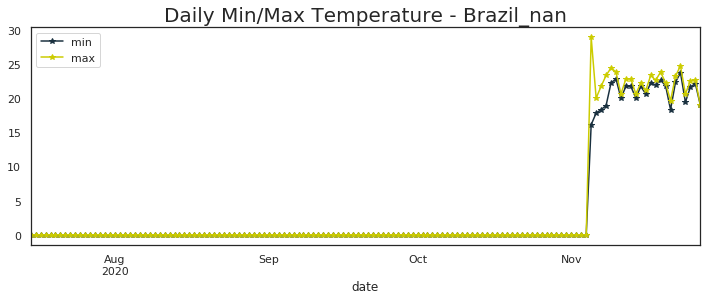

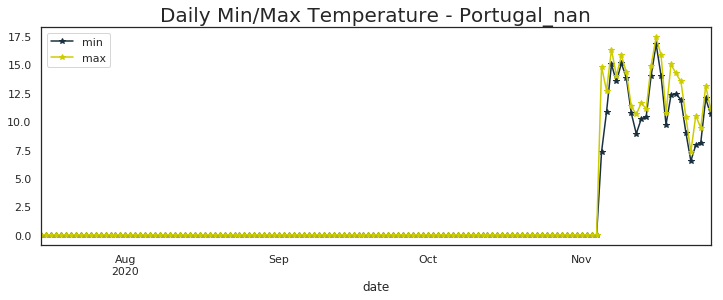

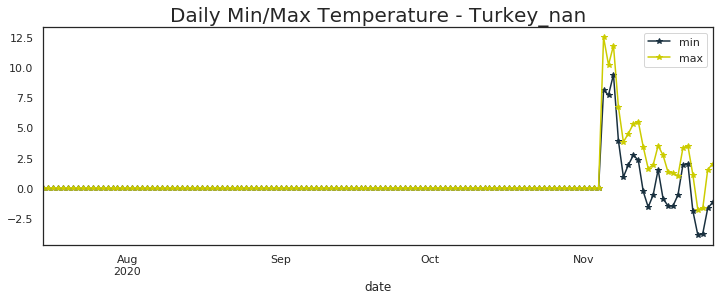

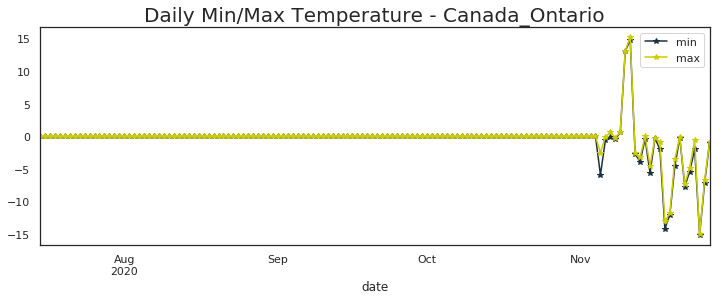

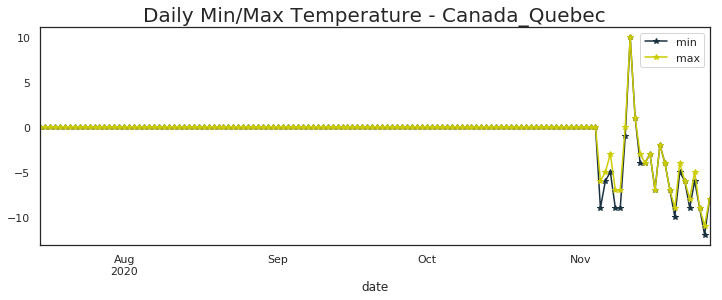

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min   max
region                                
United States_nan           17.8  17.8
India_nan                   22.0  31.0
Brazil_nan                  23.7  28.9
France_nan                  12.1  13.3
Russia_nan                   0.0   4.0
Spain_nan                   12.6  14.0
United Kingdom_nan          12.2  13.3
Italy_nan                   12.9  19.1
Argentina_nan                0.0   0.0
Colombia_nan                 0.0   0.0
Mexico_nan                  15.1  15.1
Germany_nan                 10.0  12.0
Peru_nan                    24.6  29.9
Poland_nan                   8.9  10.6
Iran_nan                    11.0  27.0
South Africa_nan             0.0   0.0
Ukraine_nan                  0.0   0.0
Belgium_nan                 13.7  14.5
Chile_nan                   17.0  22.0
Iraq_nan                     0.0   0.0
Indonesia_nan                0.0   0.0
Czechia_nan                  0.0   0.0
Turkey_nan                  

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

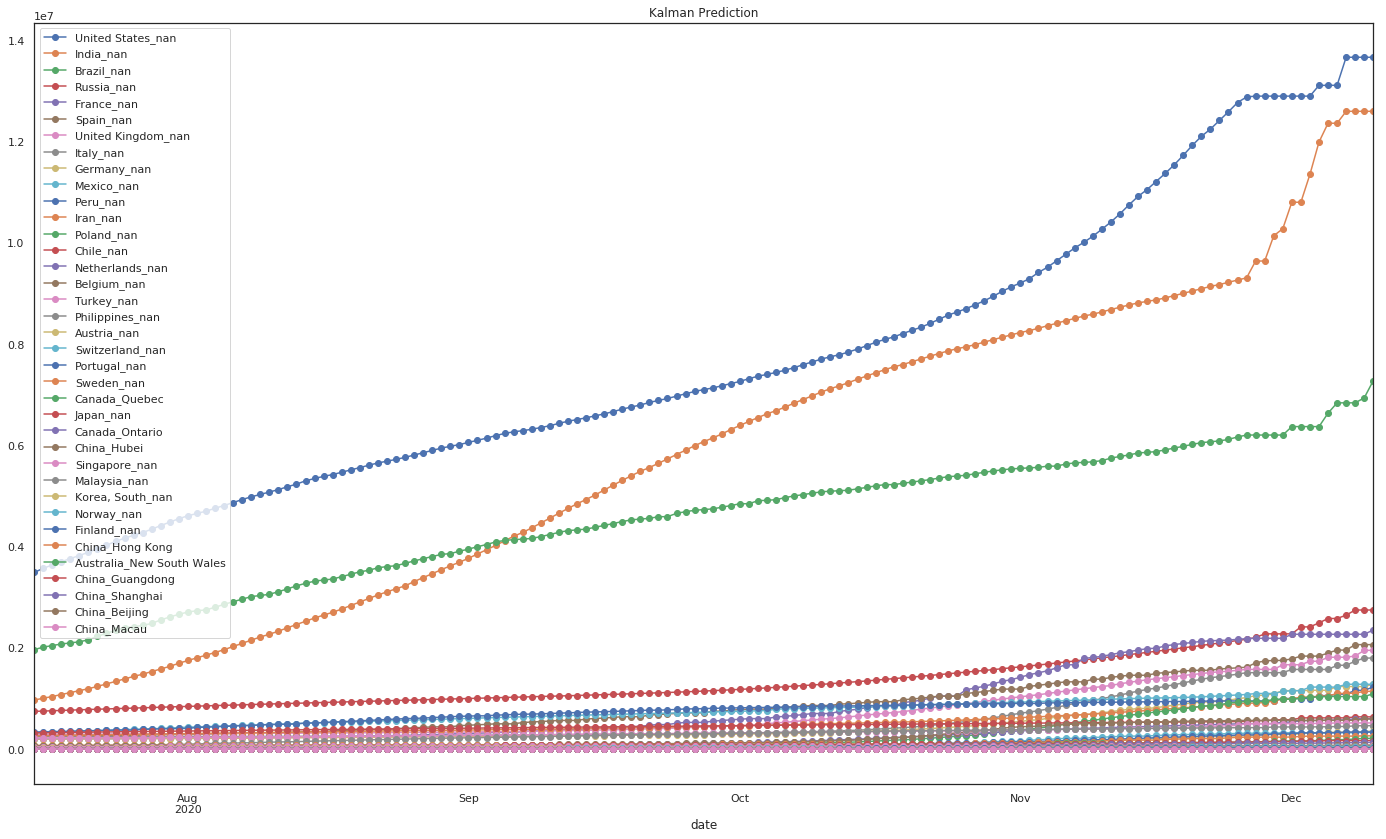

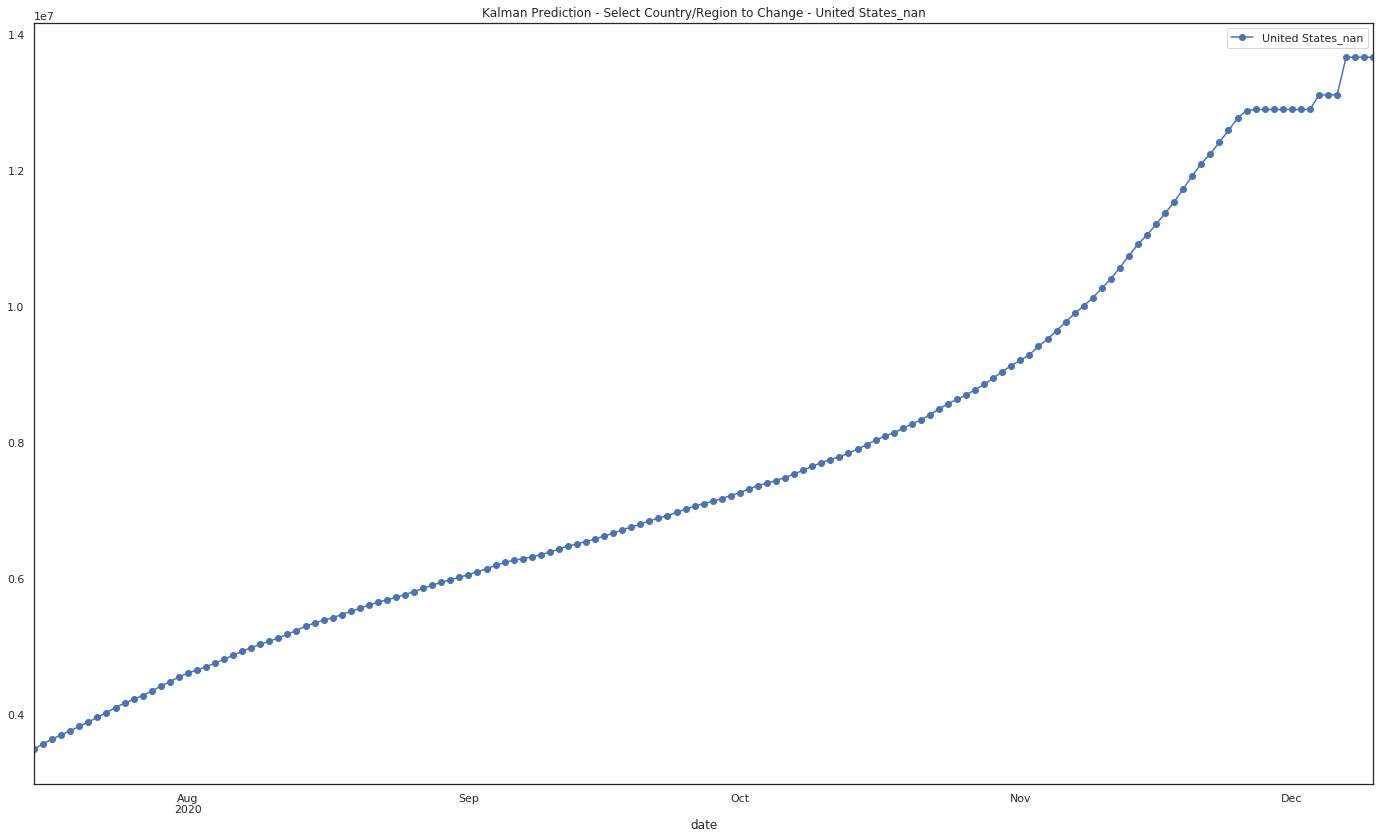

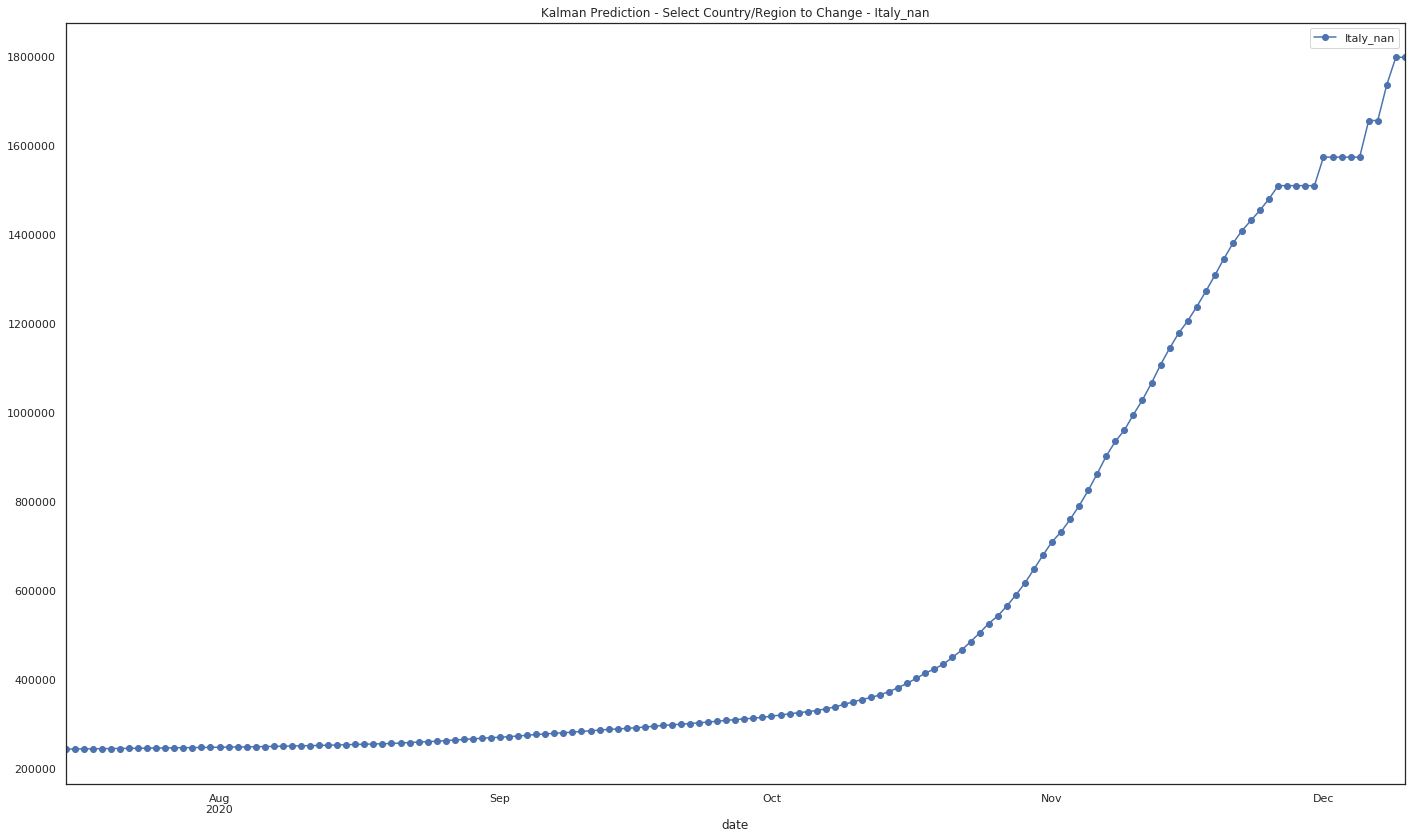

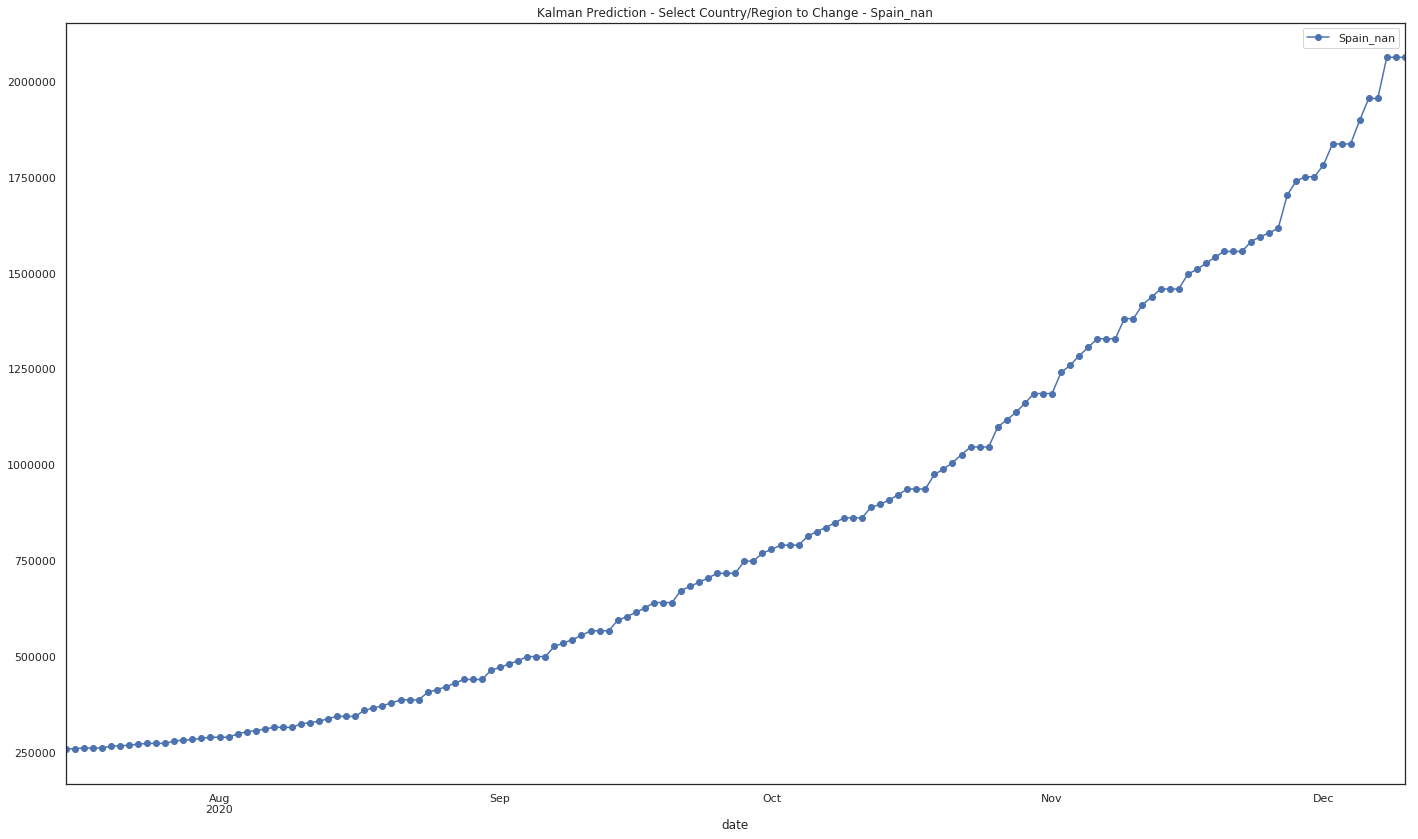

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


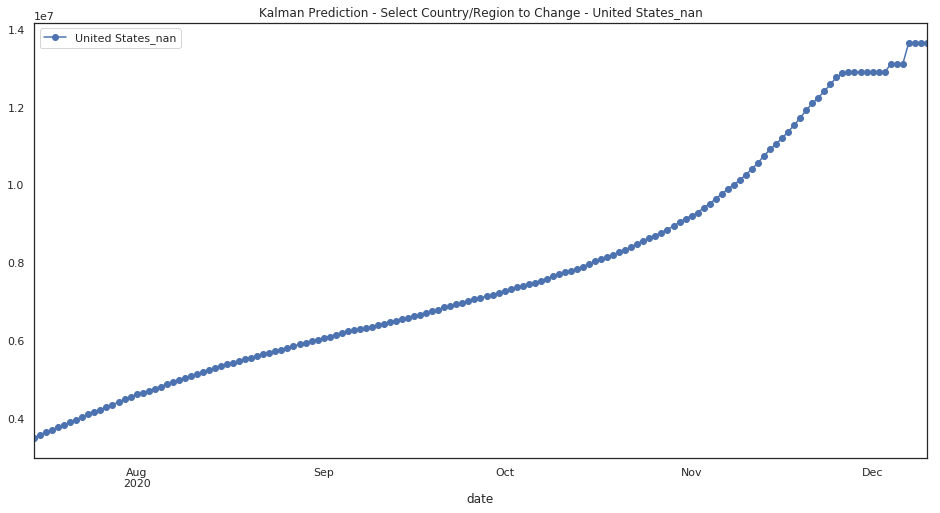

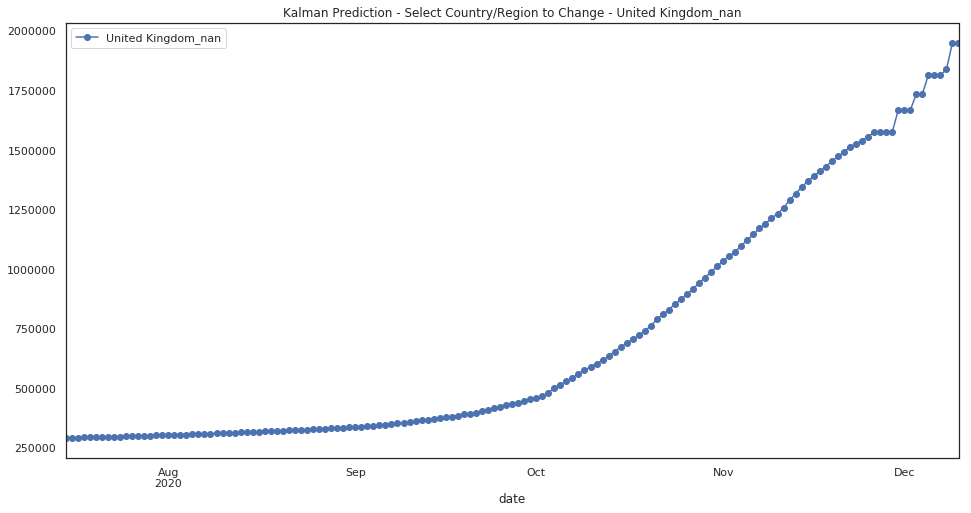

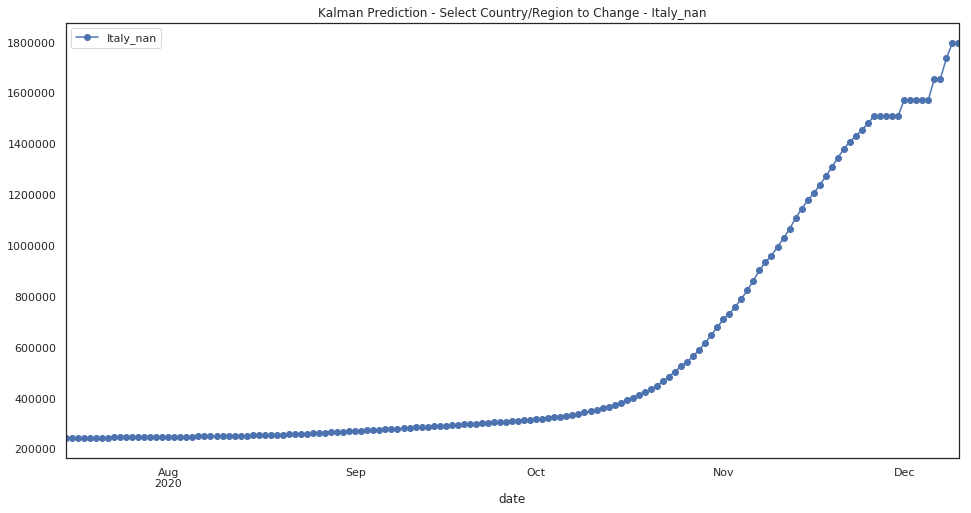

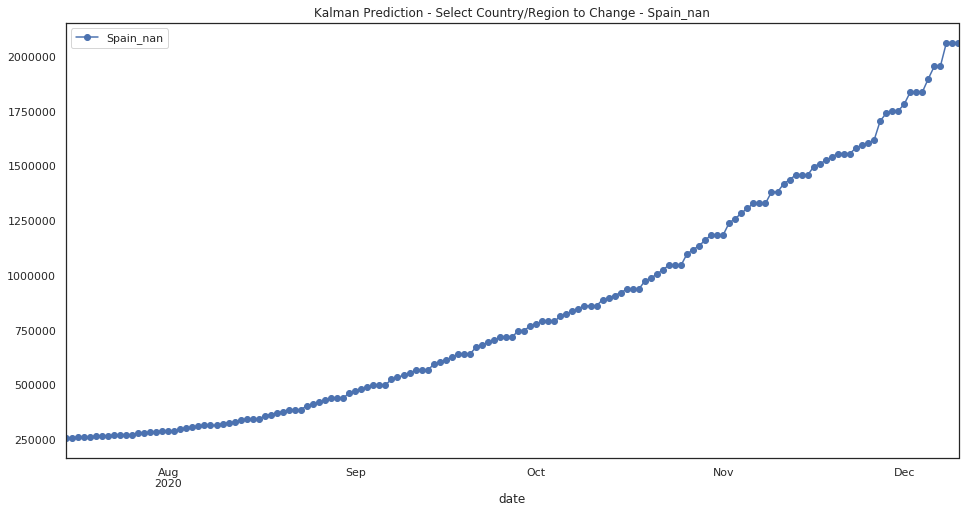

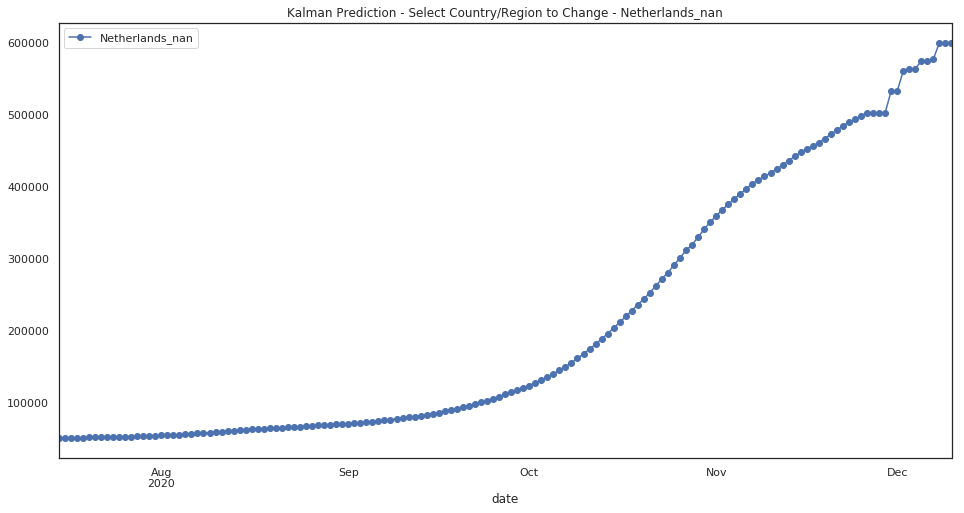

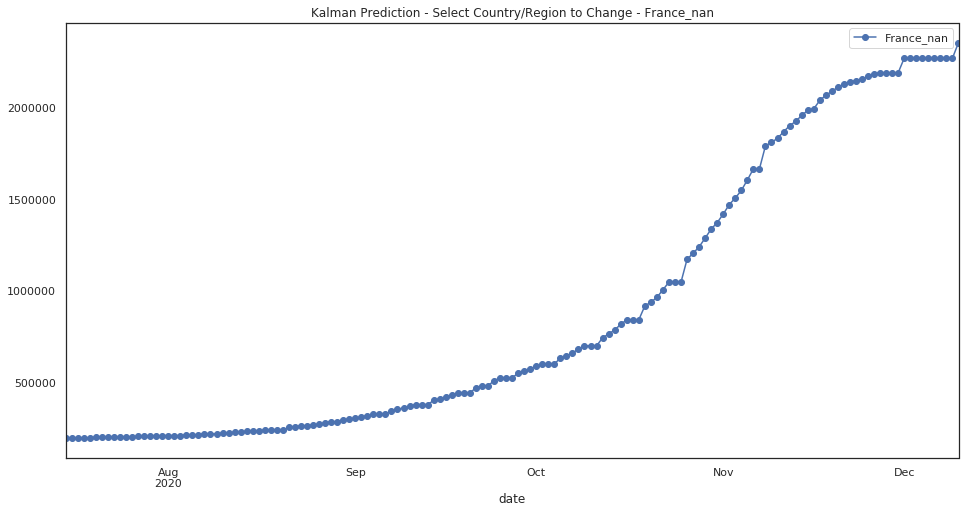

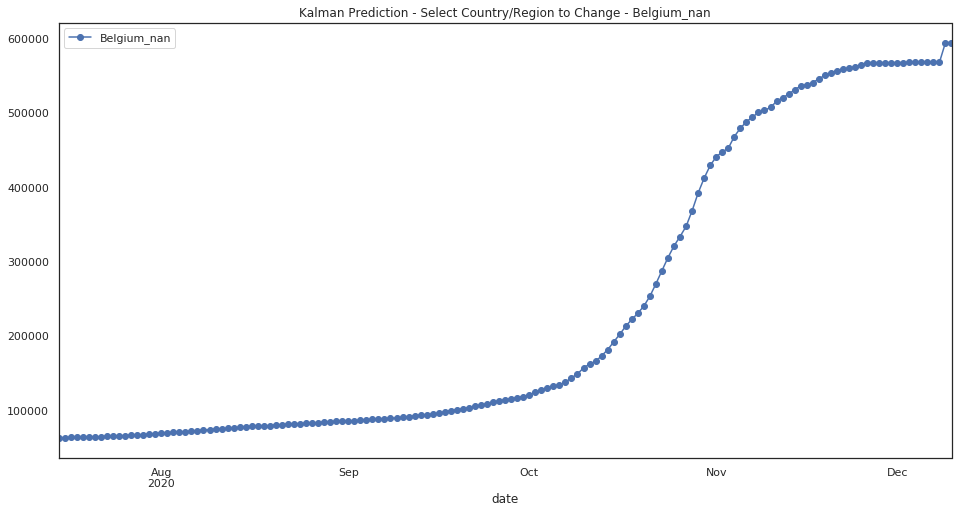

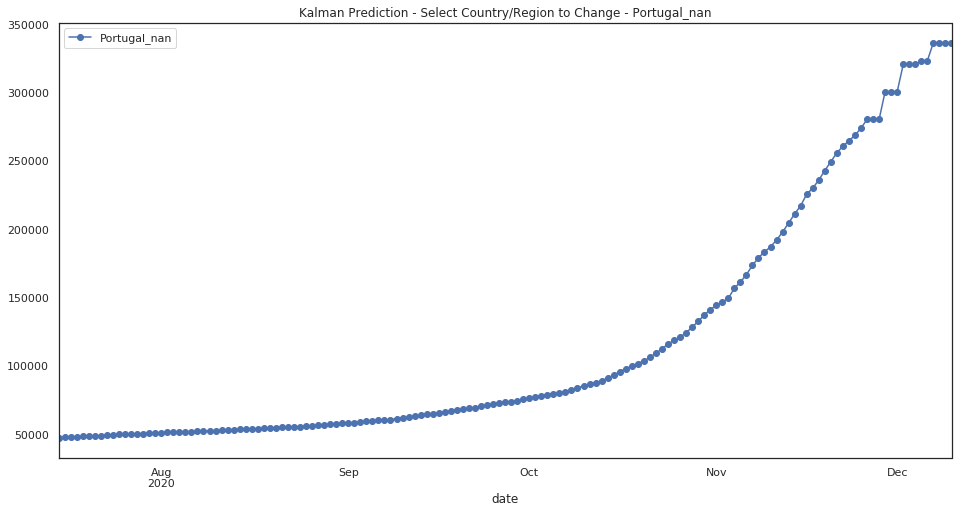

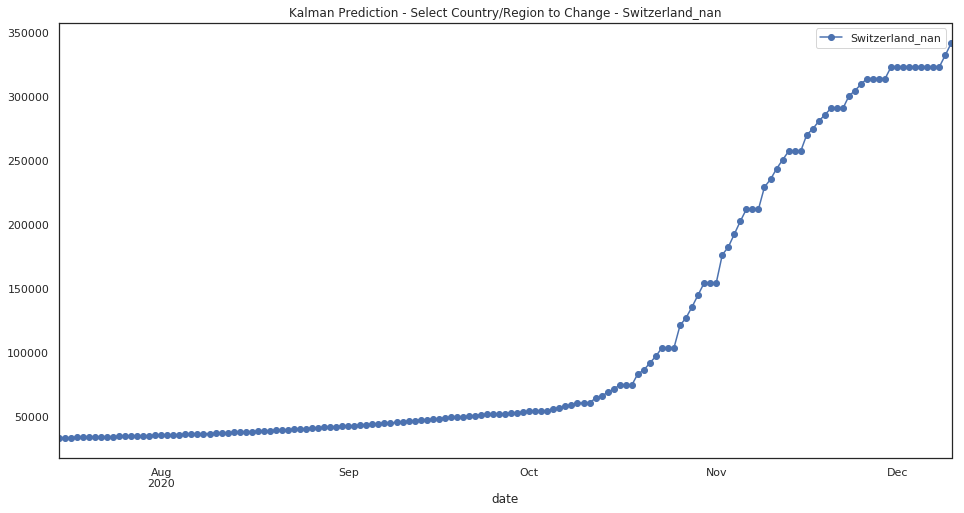

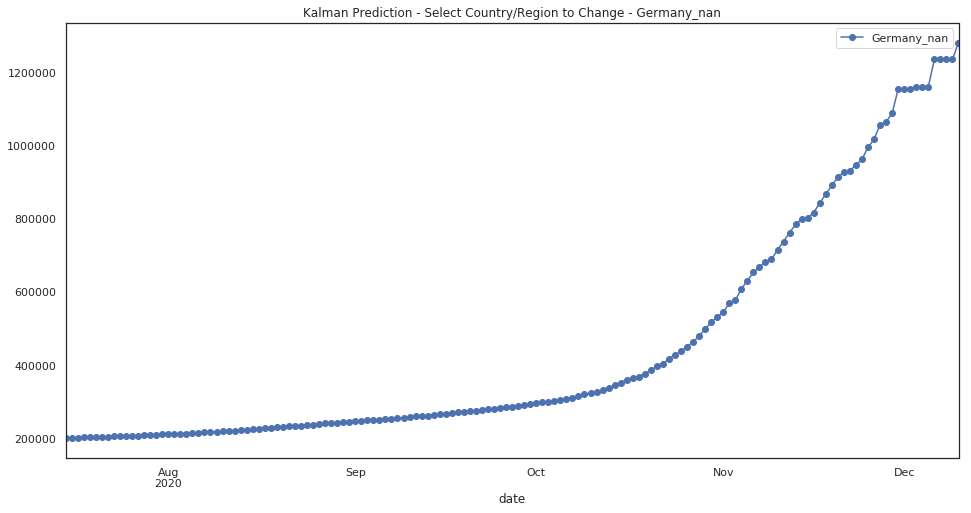

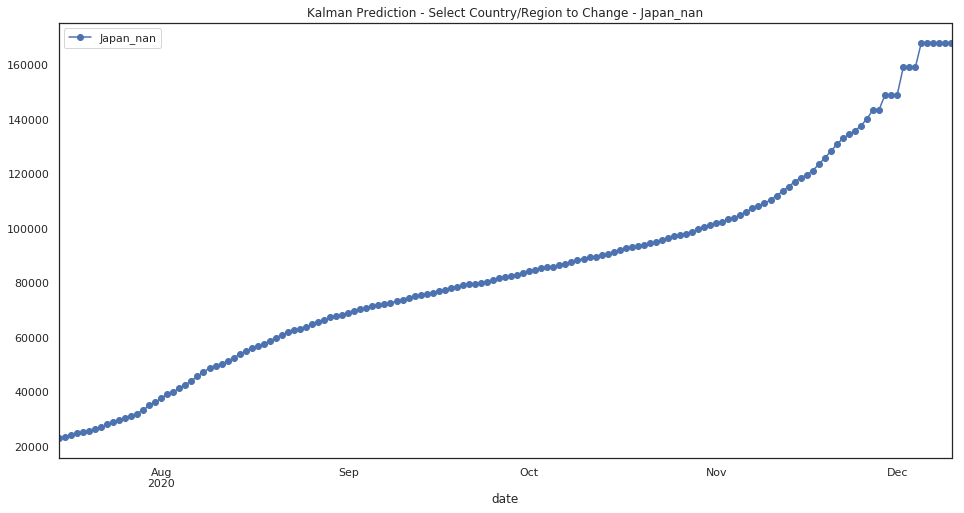

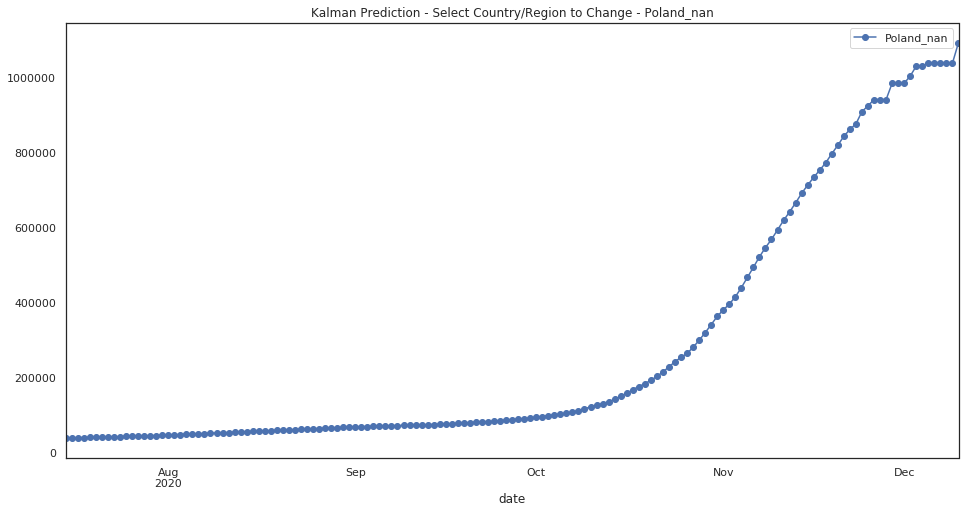

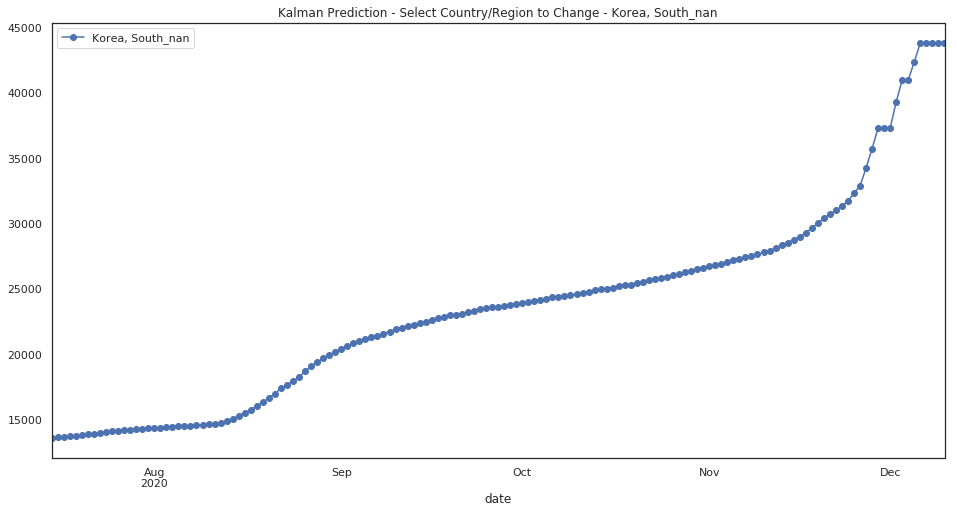

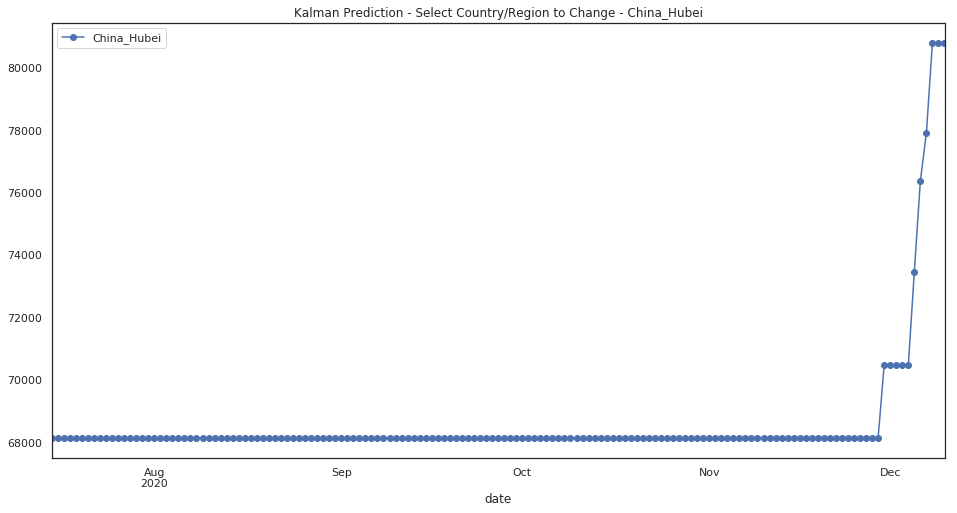

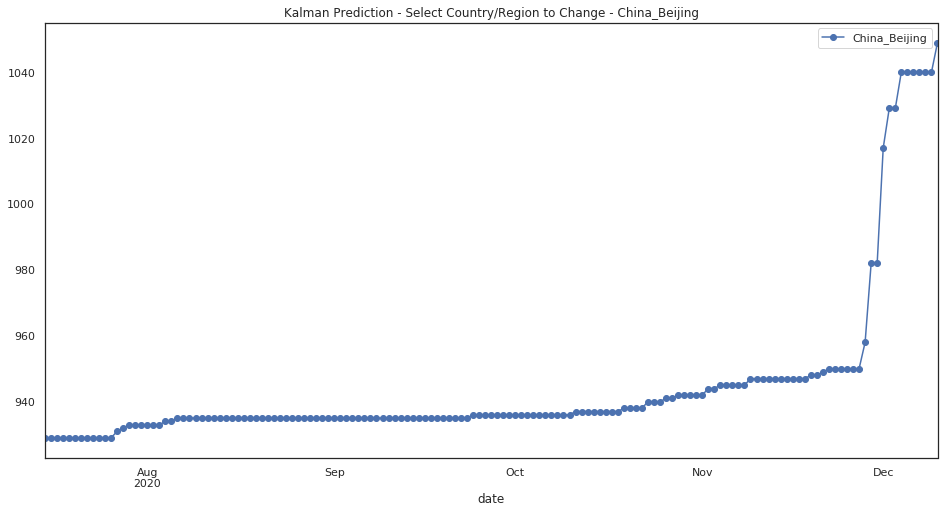

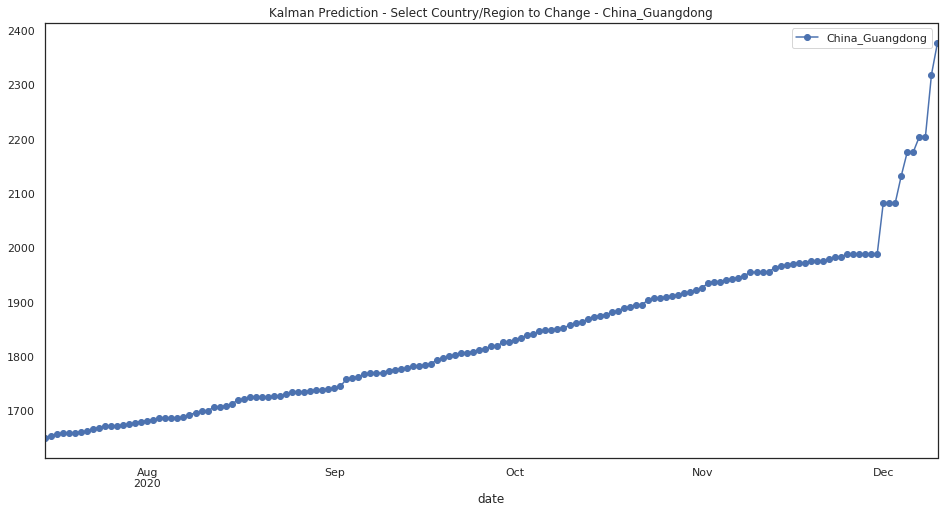

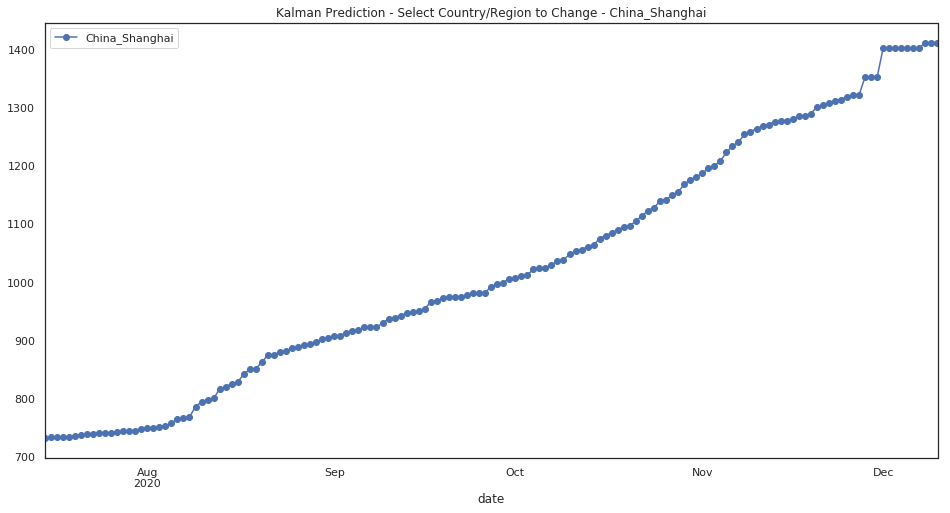

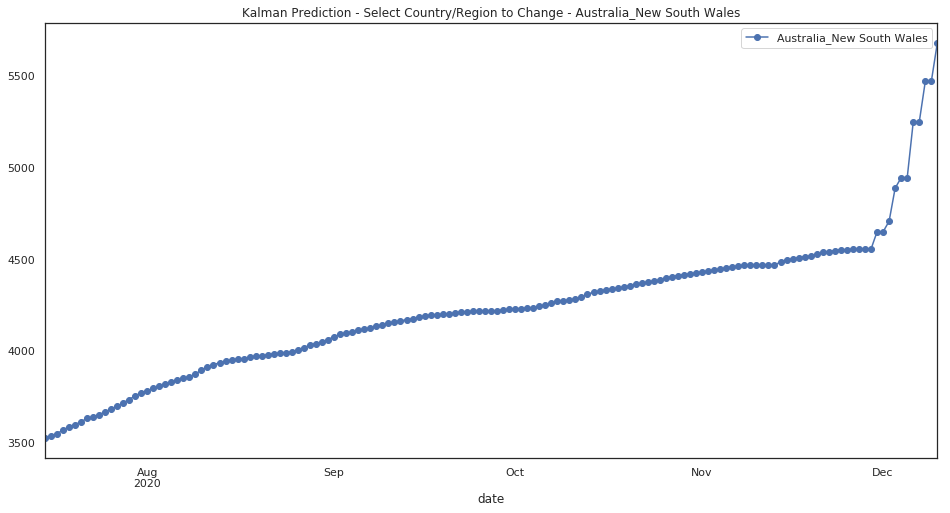

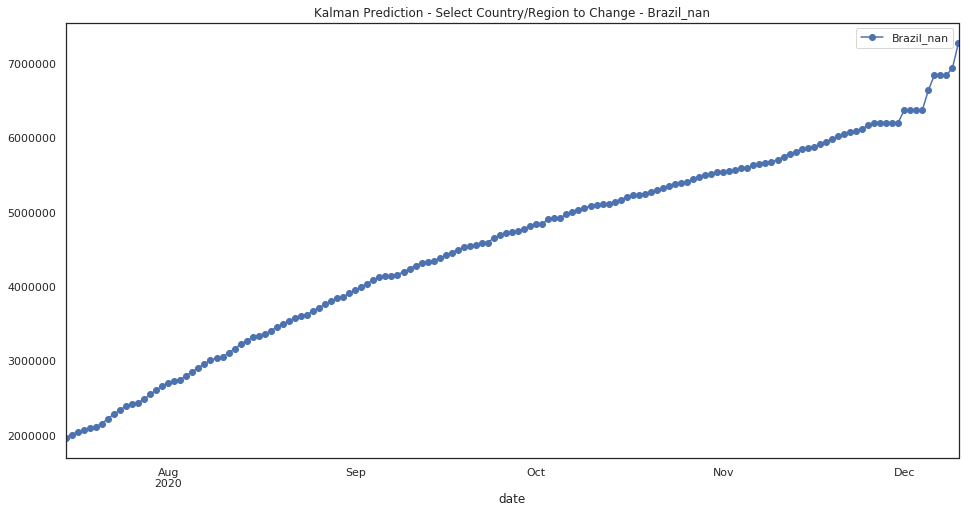

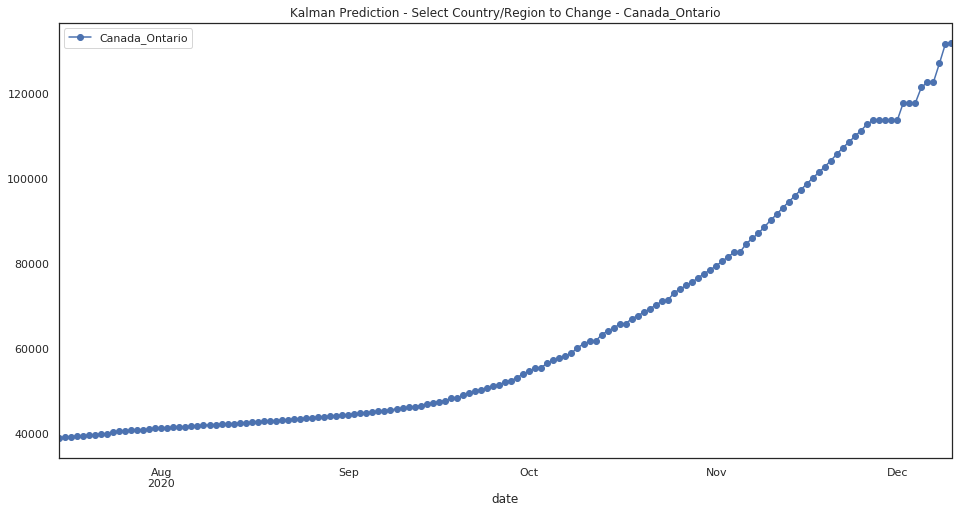

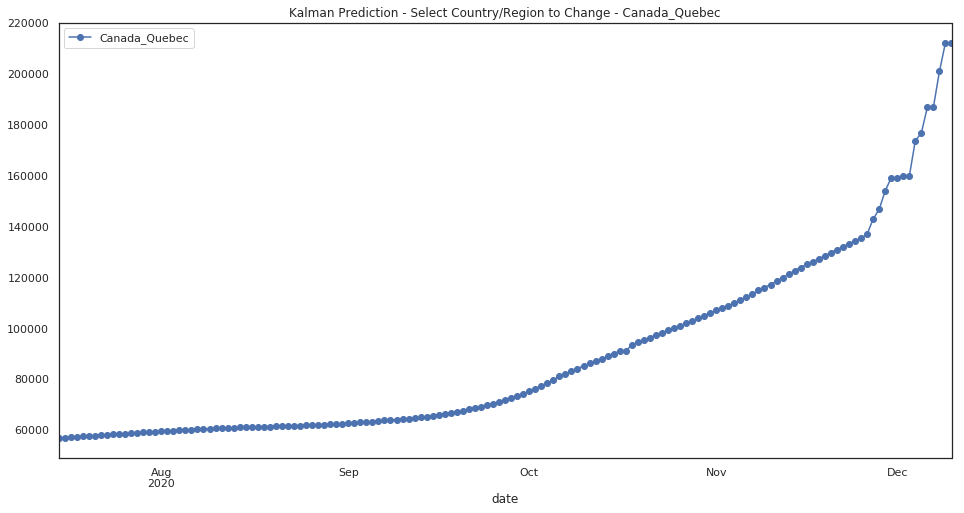

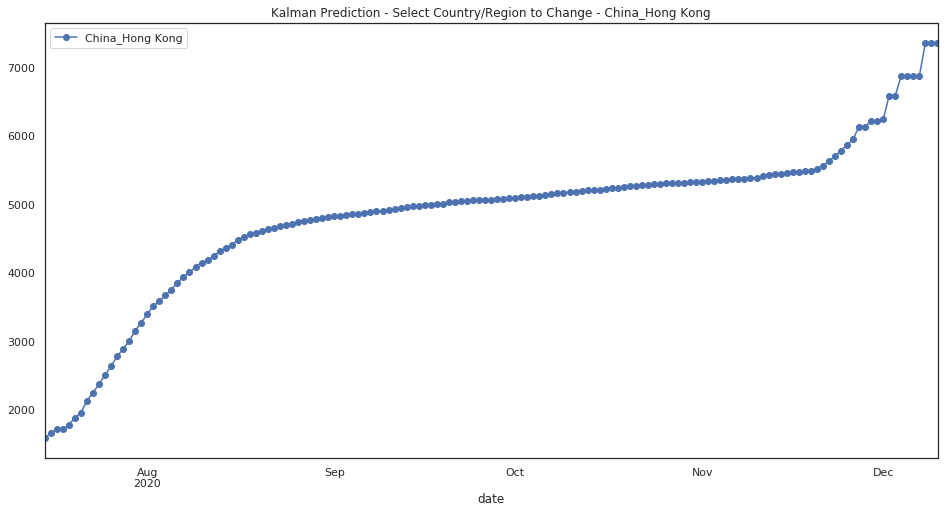

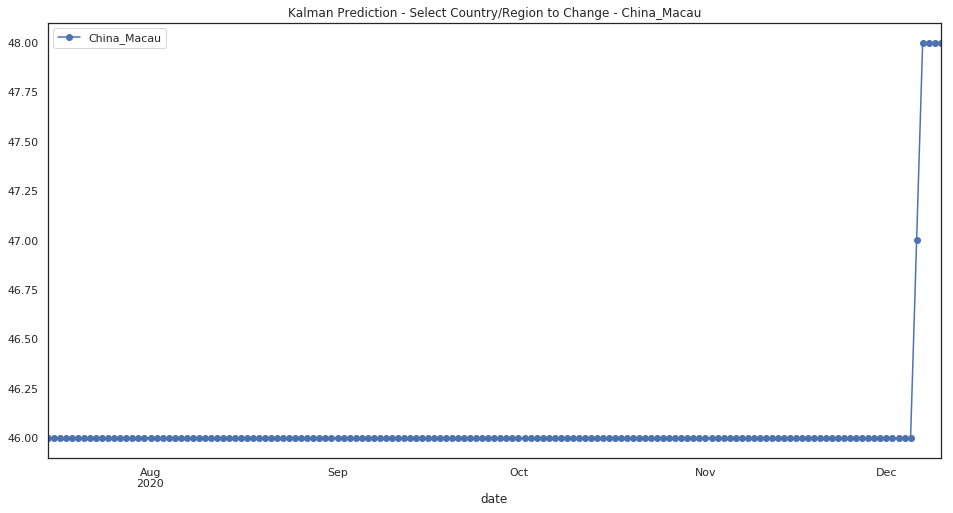

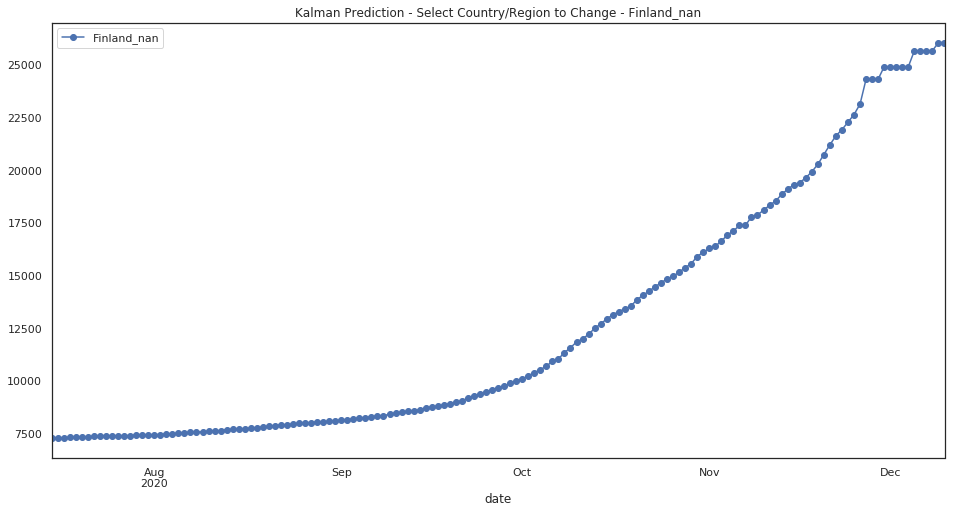

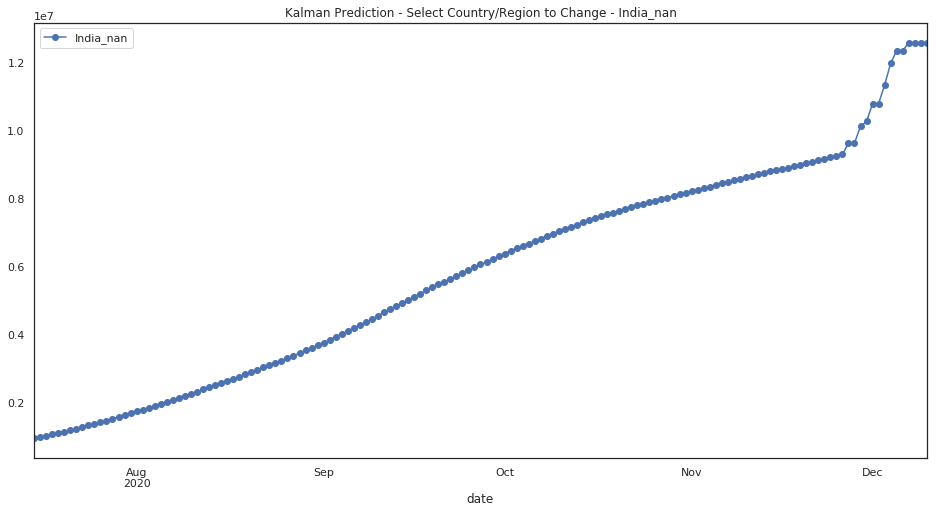

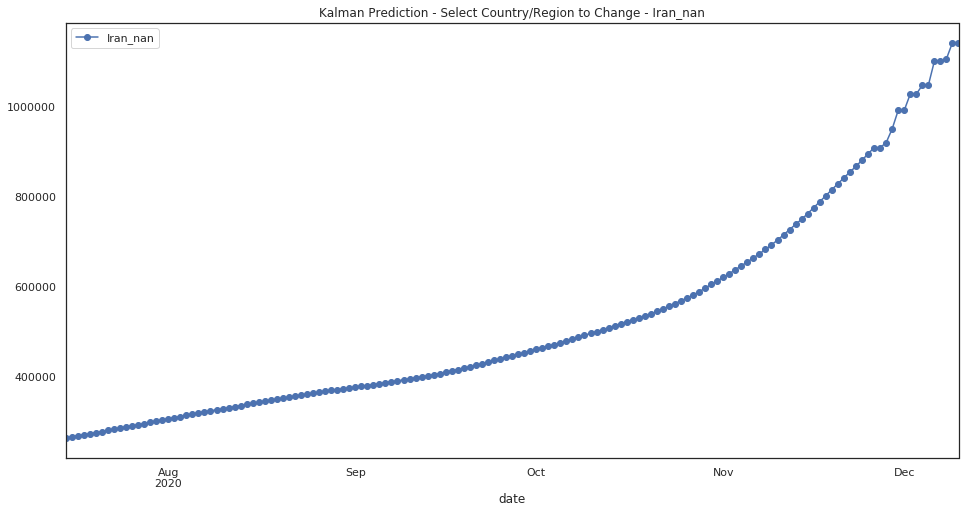

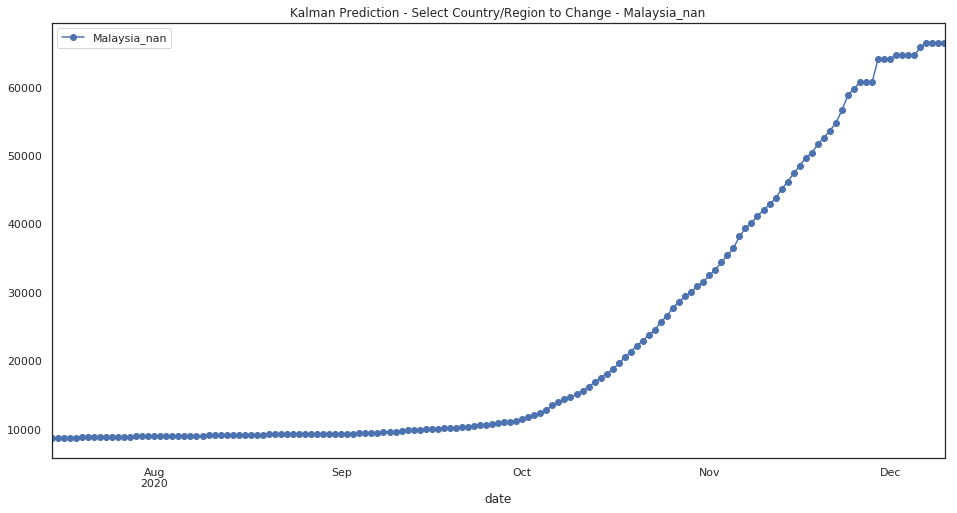

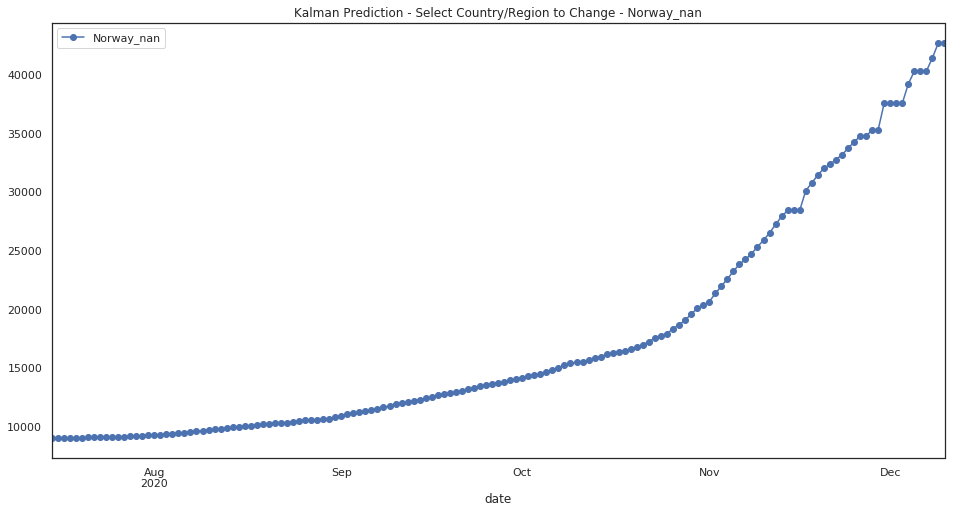

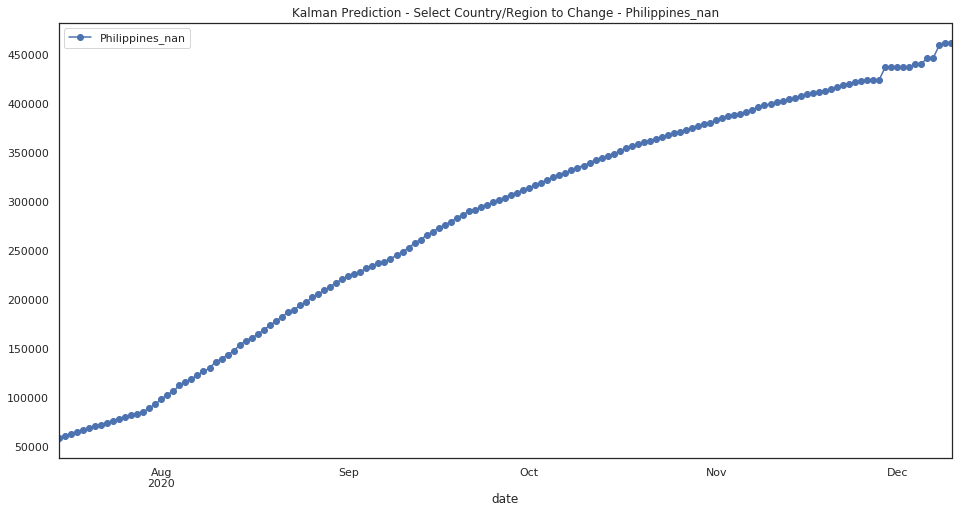

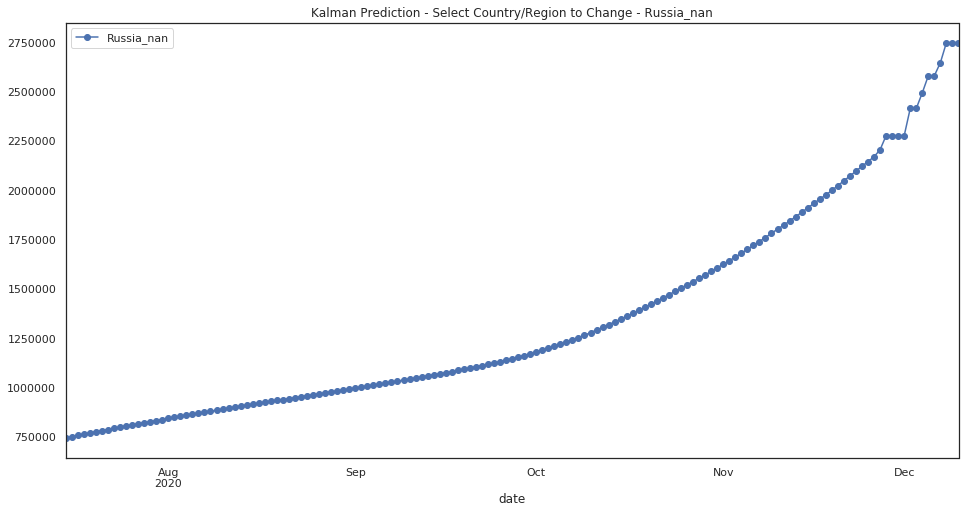

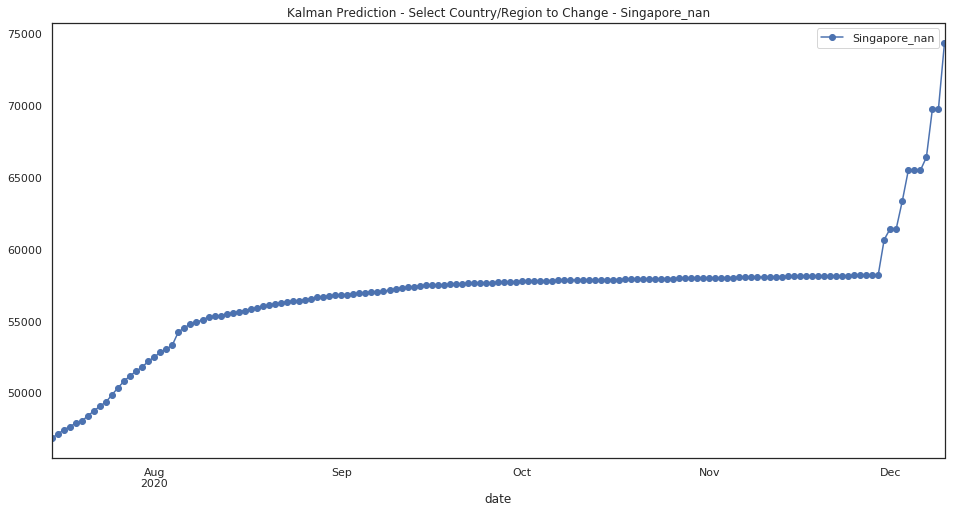

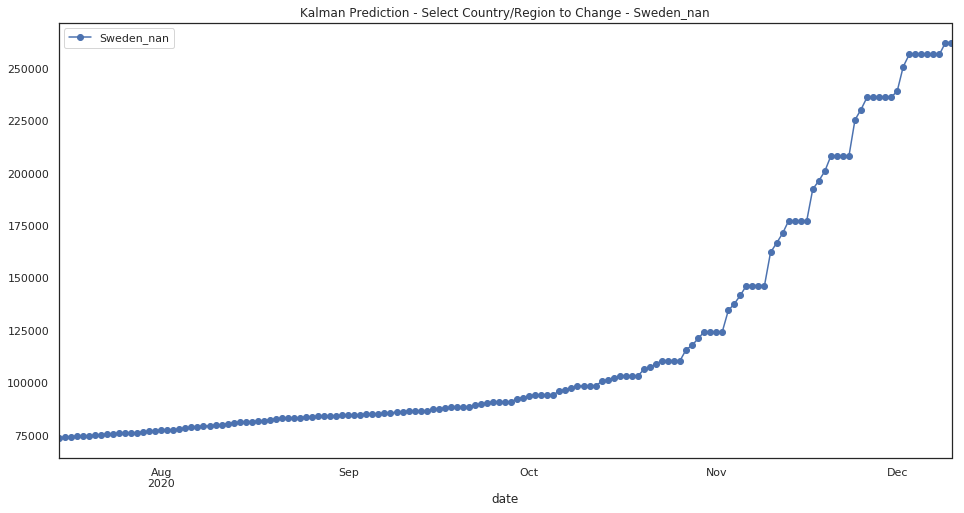

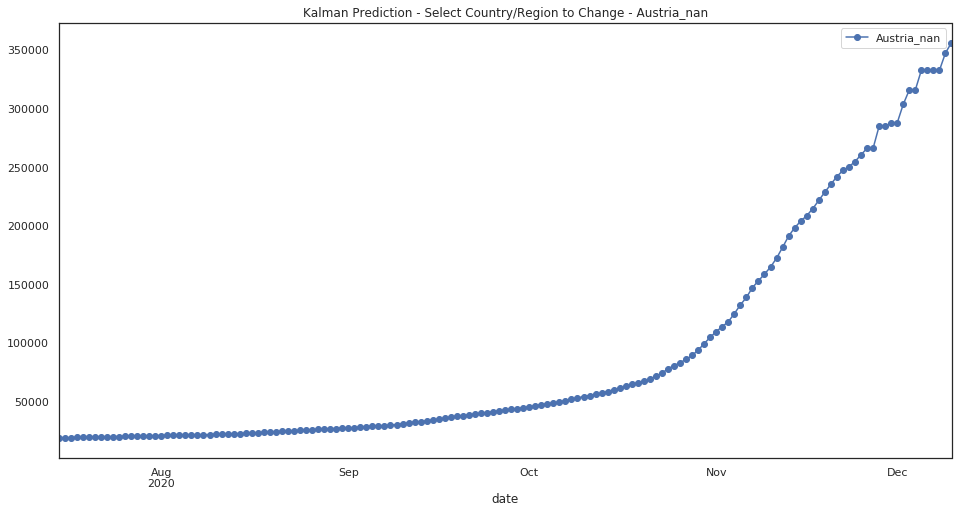

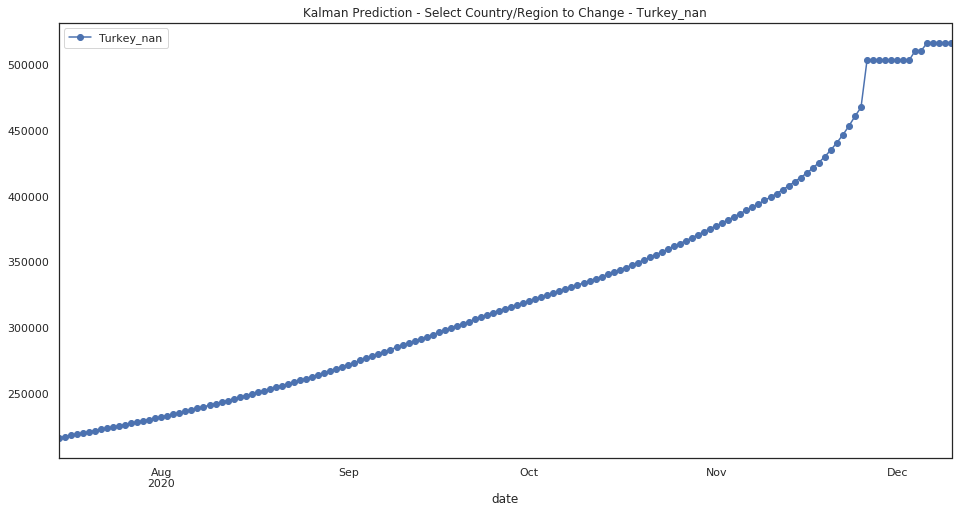

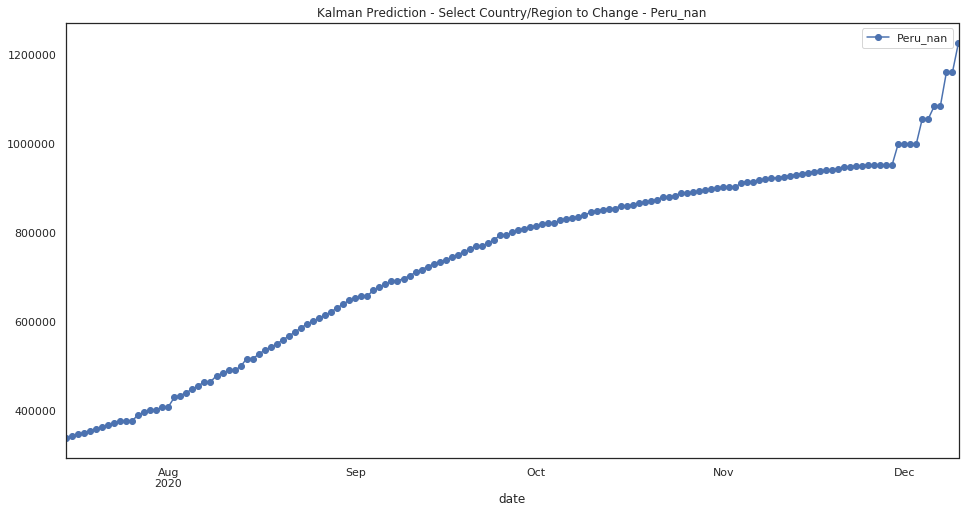

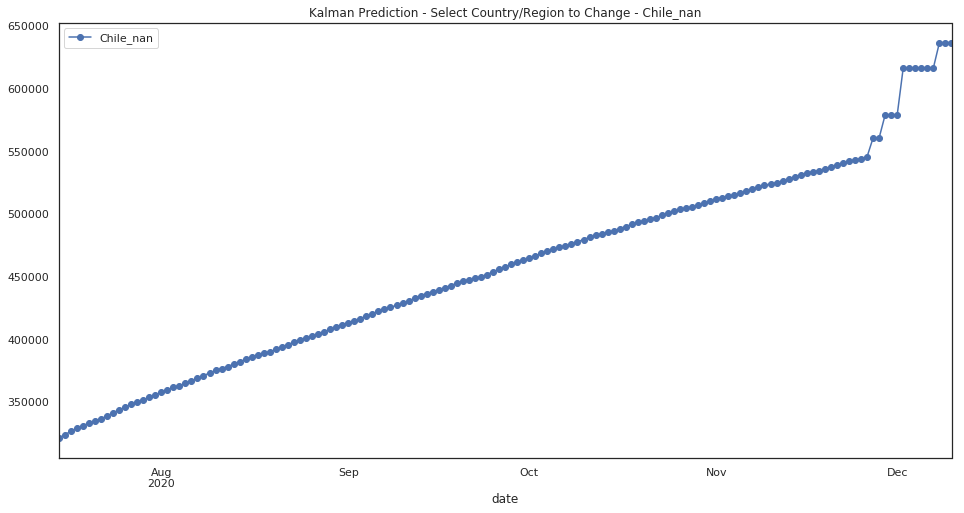

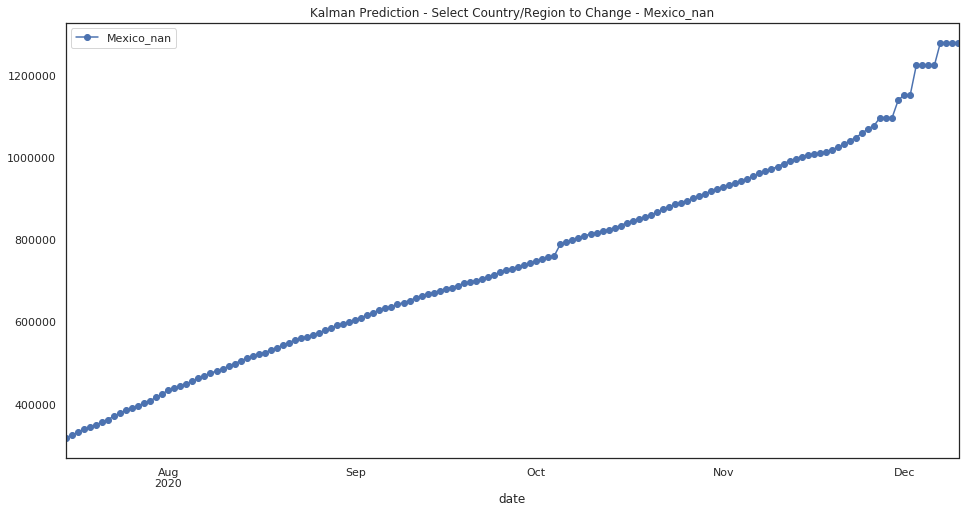

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2020-12-10 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      13667305.0
India_nan                                   NaN      12599598.0
Brazil_nan                                  NaN       7278509.0
Russia_nan                                  NaN       2747774.0
France_nan                                  NaN       2353302.0
Spain_nan                                   NaN       2063666.0
United Kingdom_nan                          NaN       1951471.0
Italy_nan                                   NaN       1798498.0
Argentina_nan                               NaN       1565323.0
Colombia_nan                                NaN       1474696.0
Germany_nan                                 NaN       1282362.0
Mexico_nan                                  NaN       1280780.0
Peru_nan                                    NaN       1227462.0
Iran_nan                                    NaN       1141364.0
Poland_nan                                  NaN       1093047.0
Ukraine_nan                                 NaN        880701.0
South Africa_nan                            NaN        831112.0
Indonesia_nan                               NaN        714294.0
Iraq_nan                                    NaN        679491.0
Chile_nan                                   NaN        636837.0
Netherlands_nan                             NaN        600588.0
Belgium_nan                                 NaN        594501.0
Romania_nan                                 NaN        588701.0
Czechia_nan                                 NaN        581949.0
Bangladesh_nan                              NaN        523705.0
Turkey_nan                                  NaN        517037.0
Pakistan_nan                                NaN        463151.0
Philippines_nan                             NaN        462438.0
Morocco_nan                                 NaN        412042.0
Saudi Arabia_nan                            NaN        376107.0
...                                         ...             ...
Dominica_nan                                NaN           101.0
Canada_Prince Edward Island                 NaN            86.0
China_Ningxia                               NaN            81.0
United Kingdom_British Virgin Islands       NaN            80.0
Canada_Yukon                                NaN            59.0
Australia_Northern Territory                NaN            57.0
Fiji_nan                                    NaN            50.0
China_Macau                                 NaN            48.0
Grenada_nan                                 NaN            47.0
Canada_Repatriated Travellers               NaN            34.0
Timor-Leste_nan                             NaN            34.0
France_New Caledonia                        NaN            33.0
Holy See_nan                                NaN            29.0
Saint Kitts and Nevis_nan                   NaN            28.0
Laos_nan                                    NaN            28.0
China_Qinghai                               NaN            20.0
Denmark_Greenland                           NaN            20.0
Solomon Islands_nan                         NaN            20.0
Canada_Northwest Territories                NaN            18.0
United Kingdom_Falkland Islands (Malvinas)  NaN            17.0
France_Saint Pierre and Miquelon            NaN            17.0
United Kingdom_Montserrat                   NaN            16.0
Canada_Grand Princess                       NaN            13.0
Western Sahara_nan                          NaN            10.0
MS Zaandam_nan                              NaN             9.0
United Kingdom_Anguilla                     NaN             4.0
Marshall Islands_nan                        NaN             4.0
China_Tibet                                 NaN             1.0
Vanuatu_nan                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[271 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          41011.0      13771.0      28609.0      11252.0   
2020-07-16          41077.0      13858.0      29119.0      11265.0   
2020-07-17          35070.0       3851.0      21355.0        877.0   
2020-07-18          35229.0       3906.0      21948.0        880.0   
2020-07-19          35301.0       4008.0      22764.0        880.0   
2020-07-20          35475.0       4090.0      23378.0        880.0   
2020-07-21          35526.0       4171.0      23961.0        884.0   
2020-07-22          35615.0       4290.0      24562.0        884.0   
2020-07-23          36003.0       4491.0      25471.0        889.0   
2020-07-24          36076.0       4509.0      26139.0        929.0   
2020-07-25          36129.0       4595.0      26750.0        897.0   
2020-07-26          36241.0       4795.0      27356.0        934.0   
2020-07-27          36351.0       4793.0      27973.0        942.0   
2020-07-28          36455.0       4938.0      28612.0        907.0   
2020-07-29          36558.0       5059.0      29231.0        955.0   
2020-07-30          36634.0       5174.0      29839.0        918.0   
2020-07-31          36758.0       5283.0      30410.0        922.0   
2020-08-01          36807.0       5416.0      30970.0        934.0   
2020-08-02          36809.0       5469.0      31492.0        960.0   
2020-08-03          36841.0       5574.0      32003.0        967.0   
2020-08-04          36878.0       5745.0      32533.0        937.0   
2020-08-05          36923.0       5836.0      33081.0        956.0   
2020-08-06          36988.0       5957.0      33651.0        981.0   
2020-08-07          37100.0       6119.0      34187.0        944.0   
2020-08-08          37151.0       6238.0      34725.0        955.0   
2020-08-09          37154.0       6390.0      35202.0        995.0   
2020-08-10          37247.0       6502.0      35744.0        997.0   
2020-08-11          37357.0       6659.0      36246.0        963.0   
2020-08-12          37437.0       6782.0      36741.0       1005.0   
2020-08-13          37514.0       6936.0      37230.0        977.0   
...                     ...          ...          ...          ...   
2020-11-12          42872.0      26160.0      65160.0       5567.0   
2020-11-13          43050.0      26651.0      66029.0       5616.0   
2020-11-14          43129.0      27168.0      66877.0       5725.0   
2020-11-15          43309.0      27753.0      67730.0       5725.0   
2020-11-16          43486.0      28351.0      68636.0       5872.0   
2020-11-17          43701.0      29035.0      69633.0       5914.0   
2020-11-18          43927.0      29740.0      70680.0       5951.0   
2020-11-19          44284.0      30518.0      71708.0       6018.0   
2020-11-20          44530.0      31348.0      72797.0       6066.0   
2020-11-21          44597.0      32099.0      73839.0       6142.0   
2020-11-22          44771.0      32692.0      74904.0       6207.0   
2020-11-23          45055.0      33462.0      75930.0       6256.0   
2020-11-24          45351.0      34208.0      77033.0       6304.0   
2020-11-25          45571.0      34866.0      78094.0       6351.0   
2020-11-26          45788.0      35521.0      79153.0       6428.0   
2020-11-27          46831.0      35988.0      81422.0       6534.0   
2020-11-28          47051.0      36042.0      85479.0       6669.0   
2020-11-29          46951.0      36040.0      86256.0       6669.0   
2020-11-30          46953.0      37746.0      85569.0       6922.0   
2020-12-01          46963.0      38023.0      88112.0       6922.0   
2020-12-02          47325.0      38047.0      91137.0       6959.0   
2020-12-03          47412.0      38074.0      94577.0       6998.0   
2020-12-04          49369.0      38211.0      96519.0       6998.0   
2020-12-05          49857.0      38244.0      99521.0       6998.0   
2020-12-06

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Russia_nan',
 'France_nan',
 'Spain_nan',
 'United Kingdom_nan',
 'Italy_nan',
 'Argentina_nan',
 'Colombia_nan',
 'Germany_nan',
 'Mexico_nan',
 'Peru_nan',
 'Iran_nan',
 'Poland_nan',
 'Ukraine_nan',
 'South Africa_nan',
 'Indonesia_nan',
 'Iraq_nan',
 'Chile_nan',
 'Netherlands_nan',
 'Belgium_nan',
 'Romania_nan',
 'Czechia_nan',
 'Bangladesh_nan',
 'Turkey_nan',
 'Pakistan_nan',
 'Philippines_nan',
 'Morocco_nan',
 'Saudi Arabia_nan',
 'Austria_nan',
 'Switzerland_nan',
 'Israel_nan',
 'Portugal_nan',
 'Nepal_nan',
 'Sweden_nan',
 'Jordan_nan',
 'Hungary_nan',
 'United Arab Emirates_nan',
 'Canada_Quebec',
 'Ecuador_nan',
 'Serbia_nan',
 'Dominican Republic_nan',
 'Georgia_nan',
 'Panama_nan',
 'Bolivia_nan',
 'Armenia_nan',
 'Japan_nan',
 'Qatar_nan',
 'Bulgaria_nan',
 'Guatemala_nan',
 'Costa Rica_nan',
 'Croatia_nan',
 'Kuwait_nan',
 'Lebanon_nan',
 'Belarus_nan',
 'Oman_nan',
 'Kazakhstan_nan',
 'Canada_Ontario',
 'Moldova_n

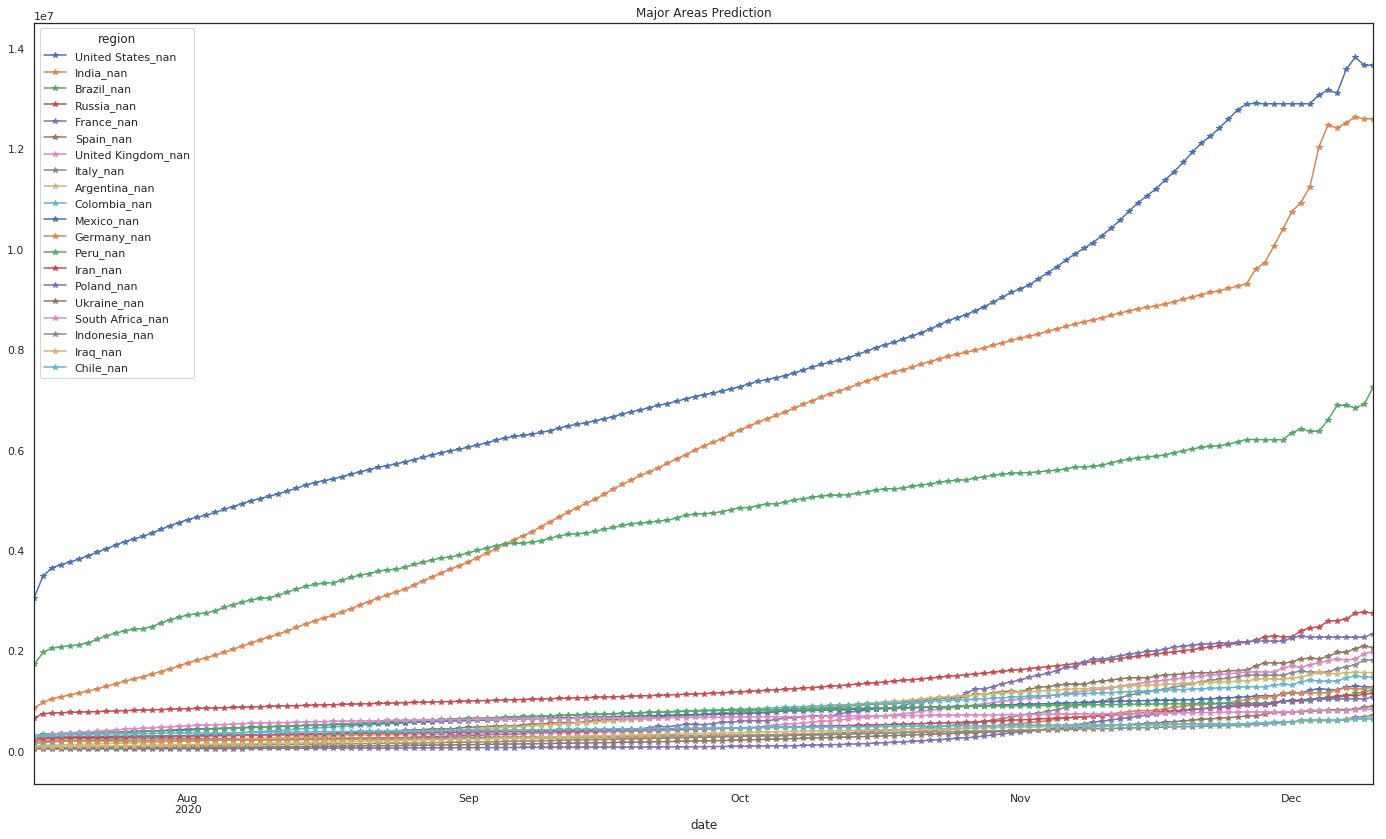

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

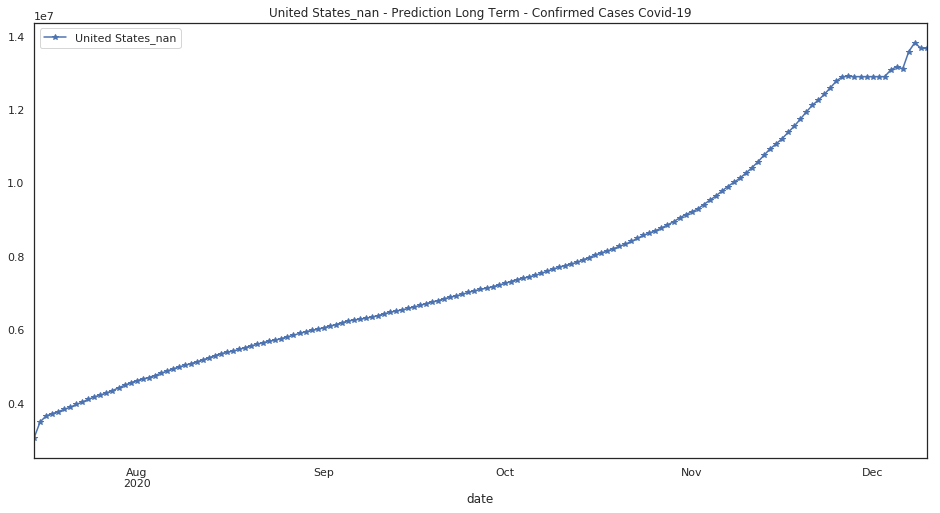

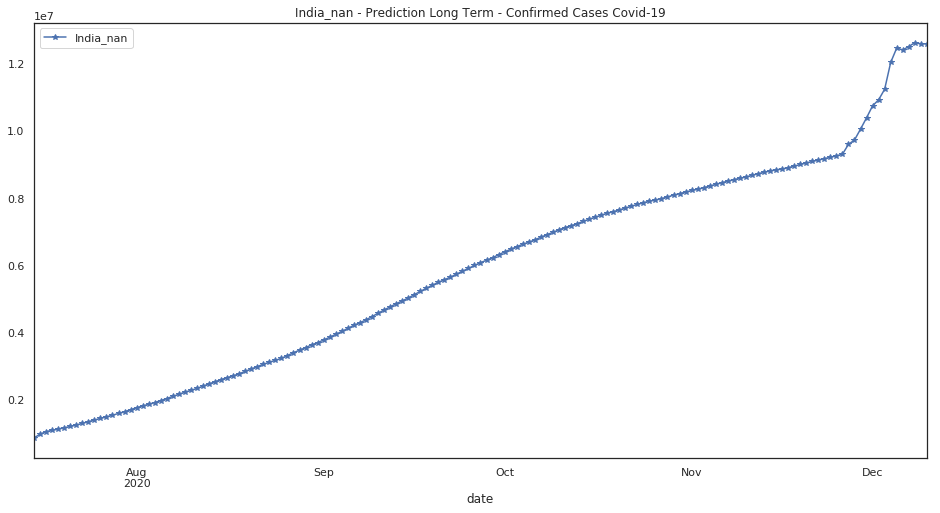

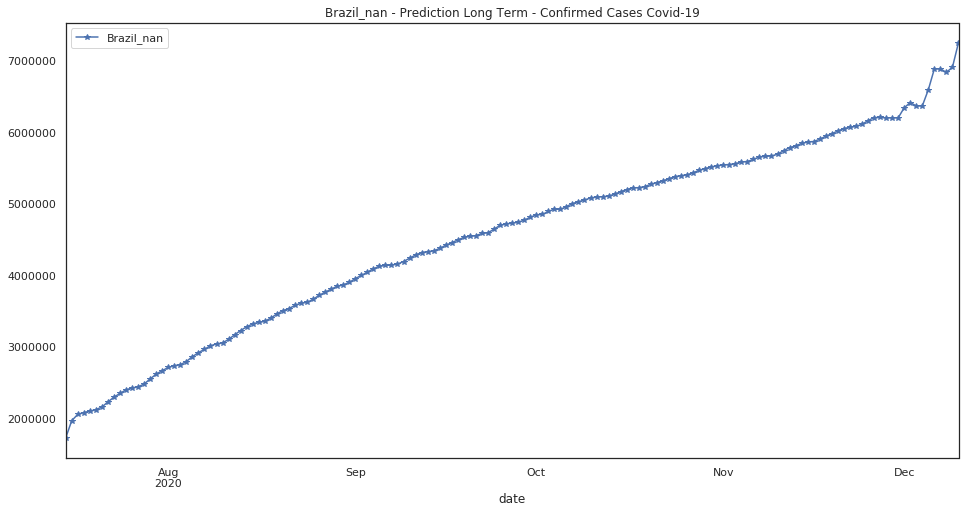

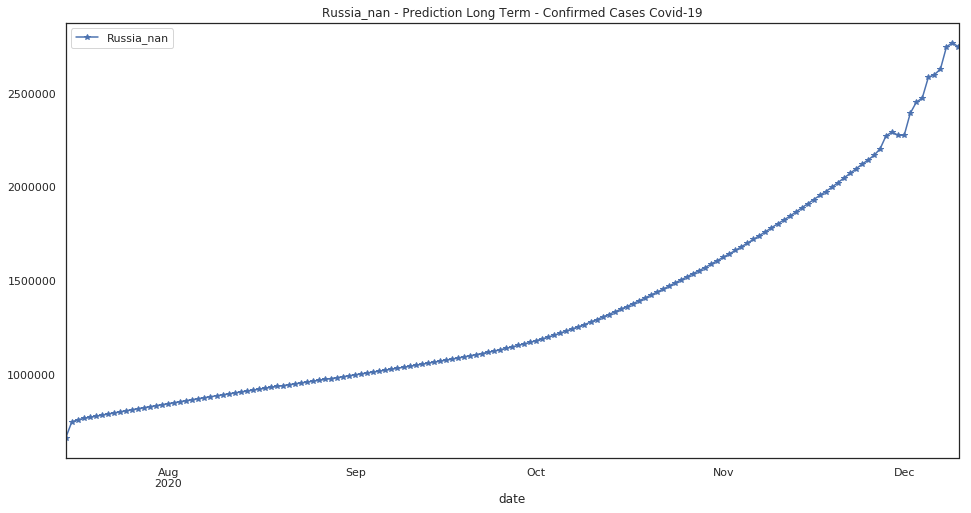

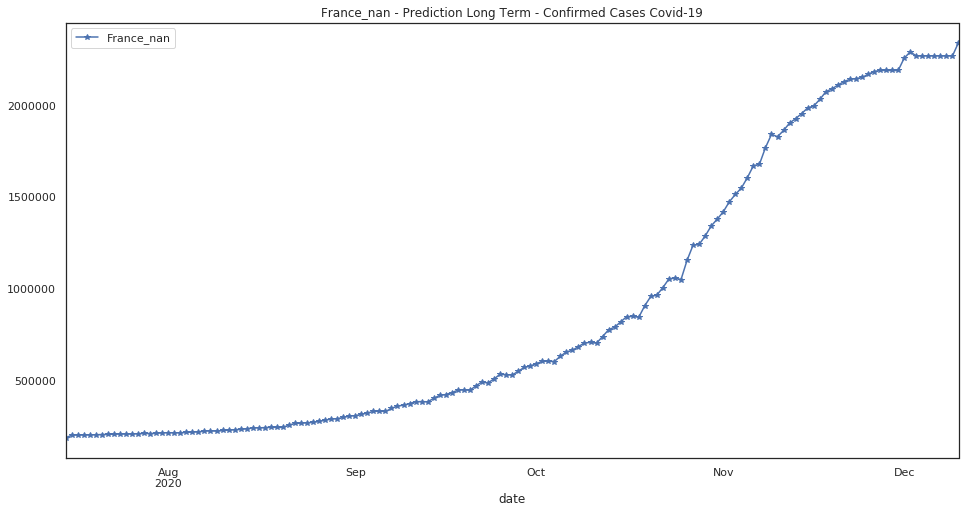

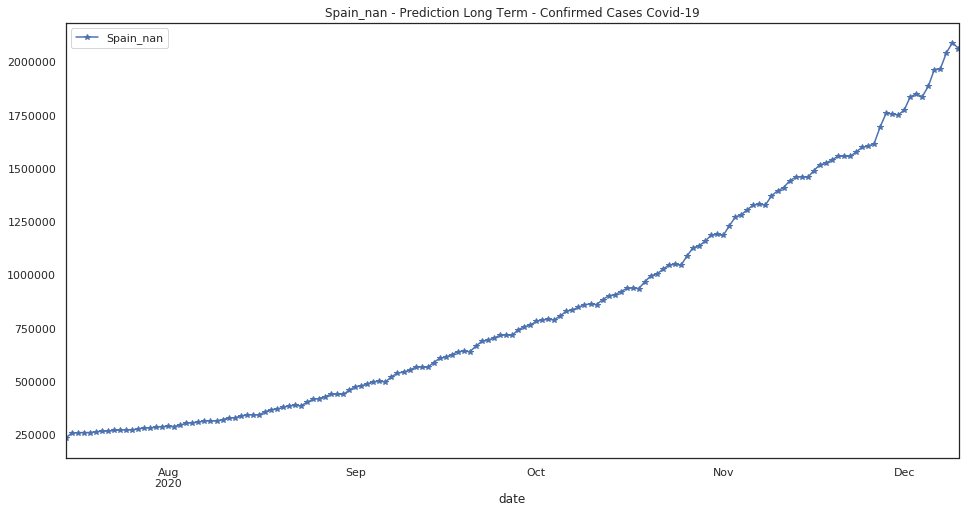

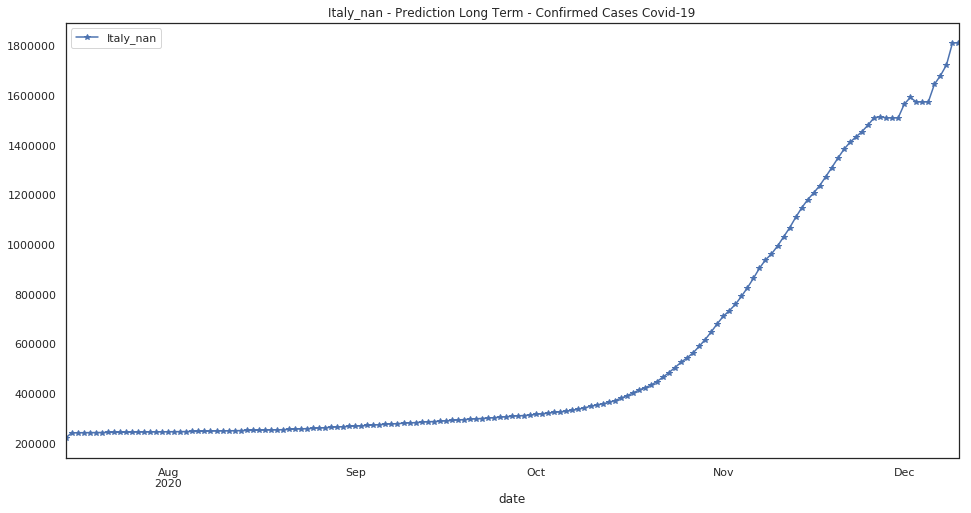

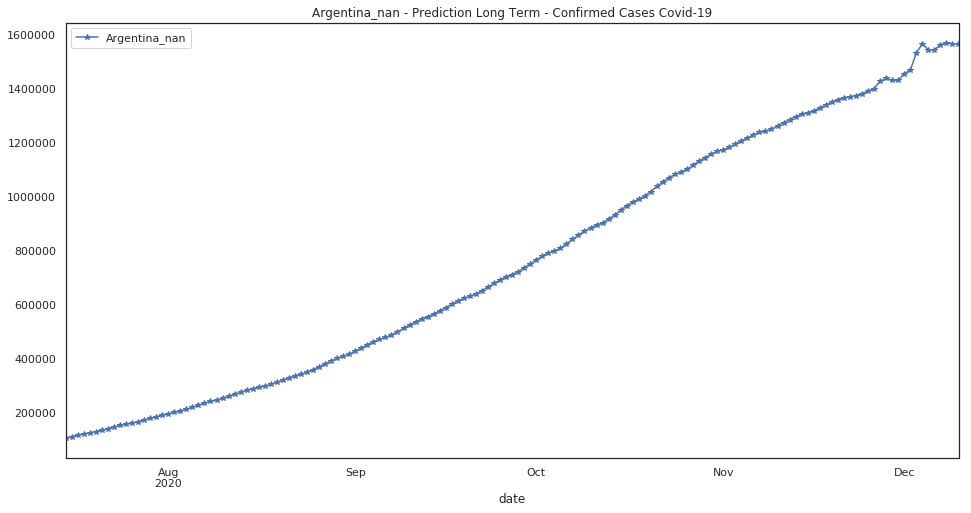

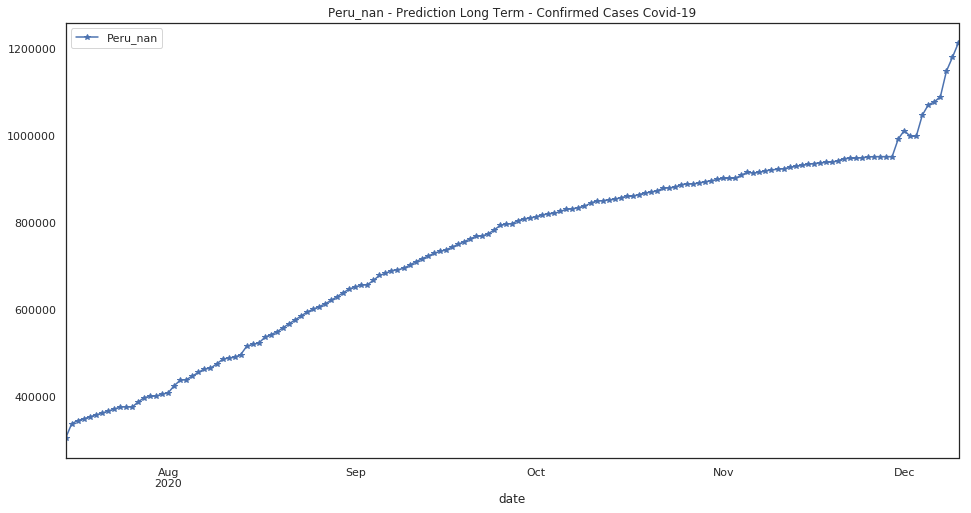

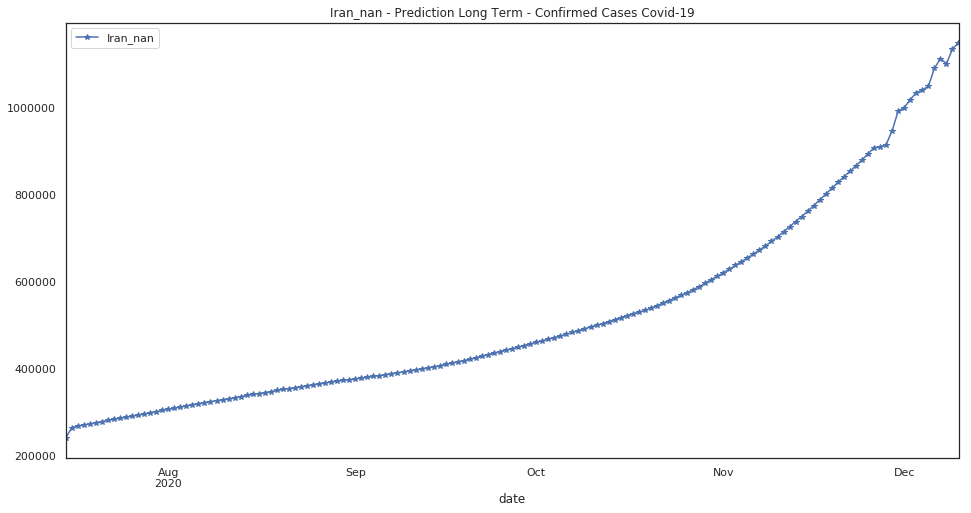

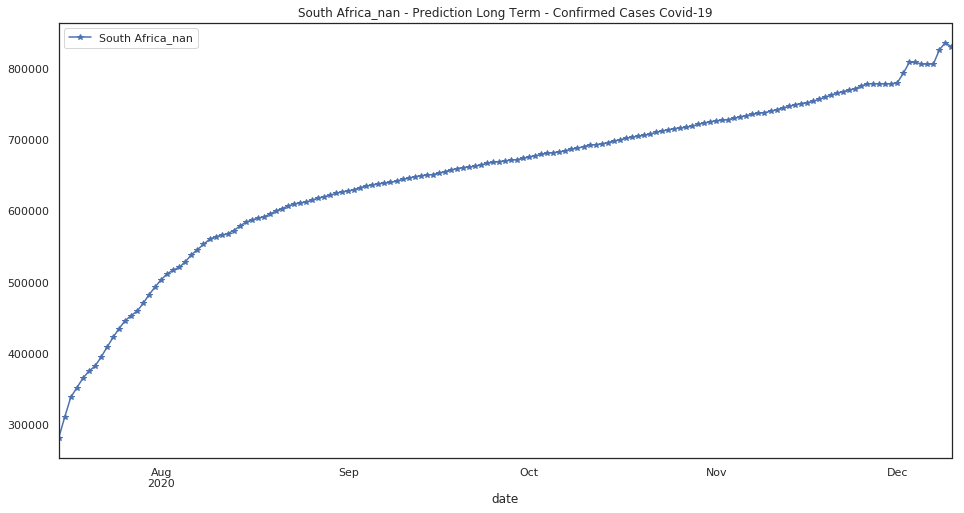

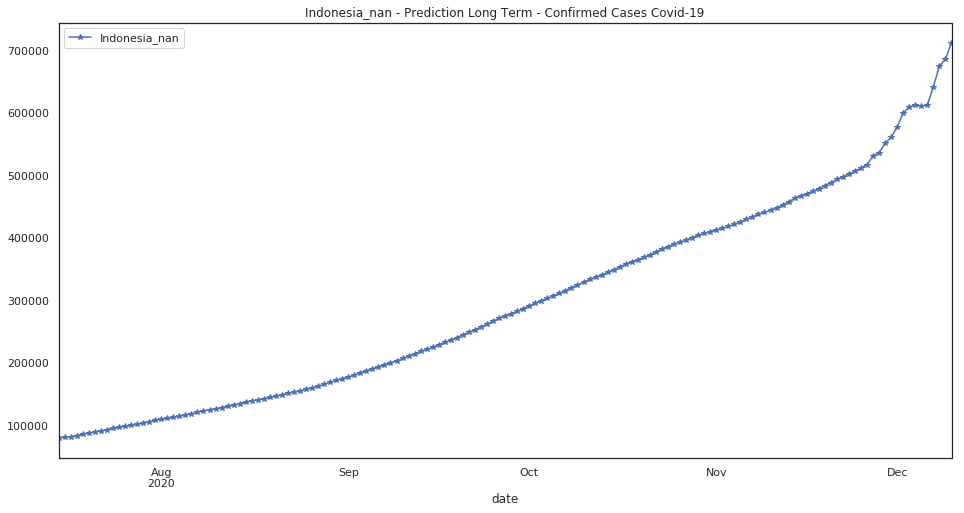

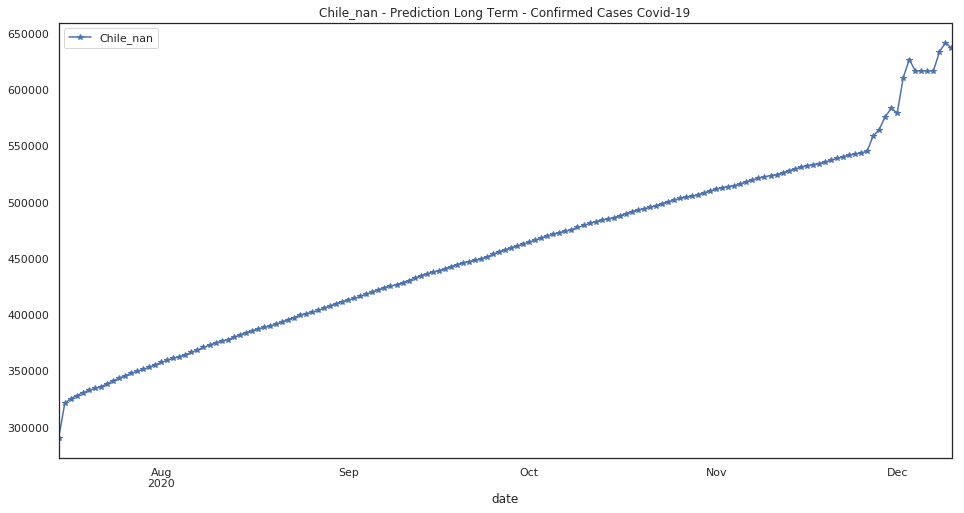

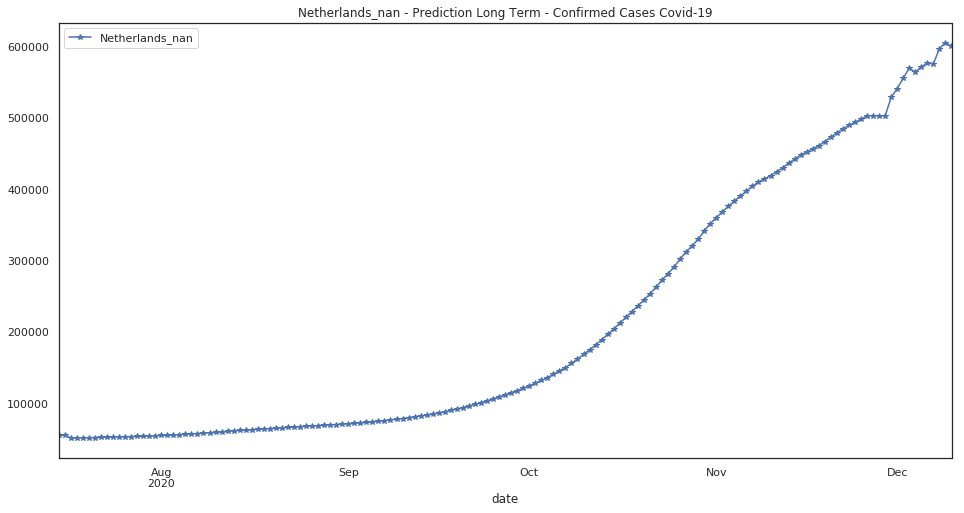

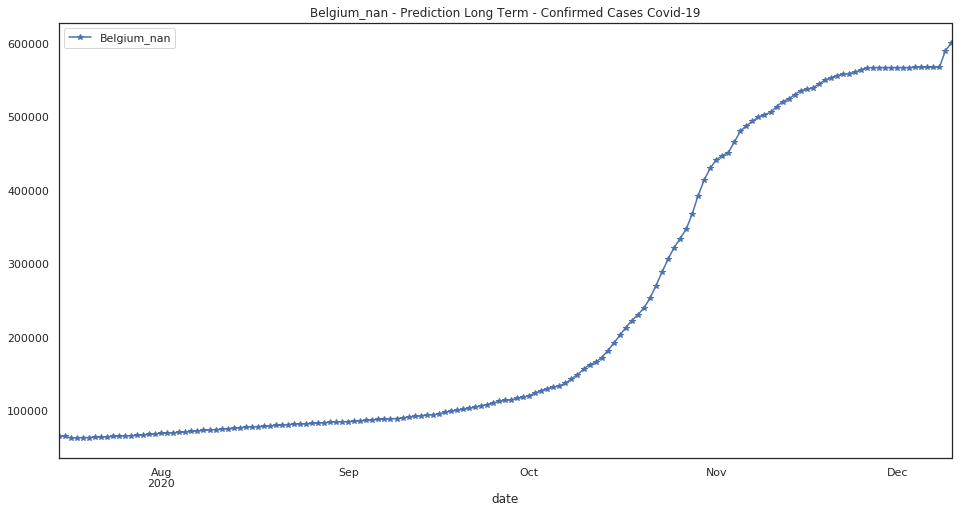

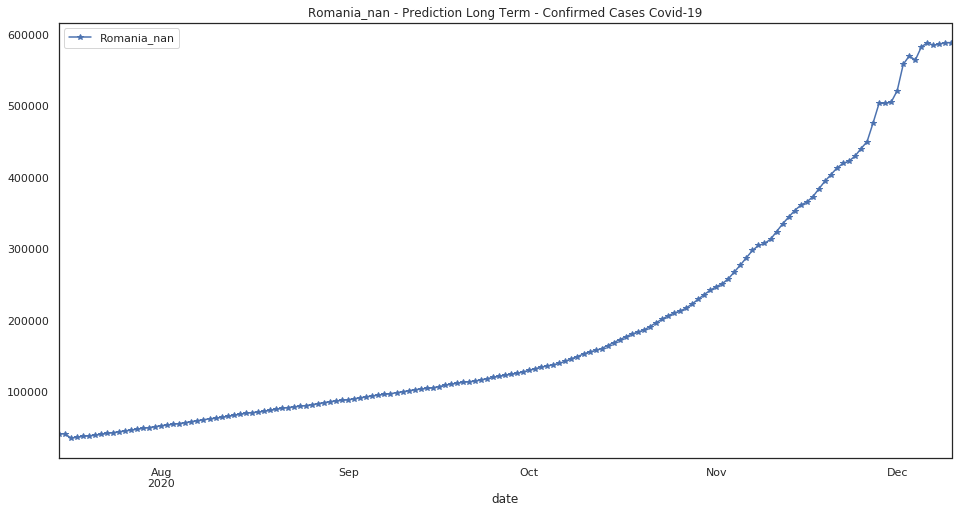

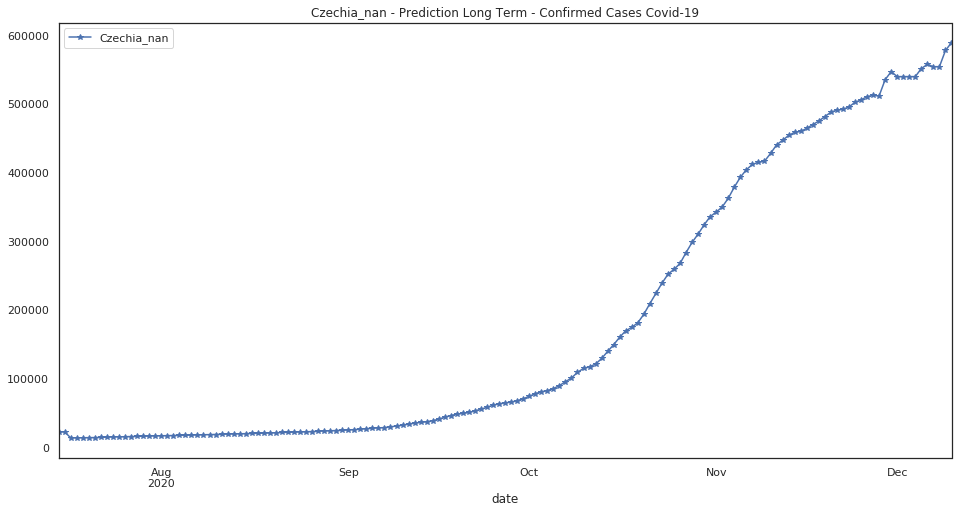

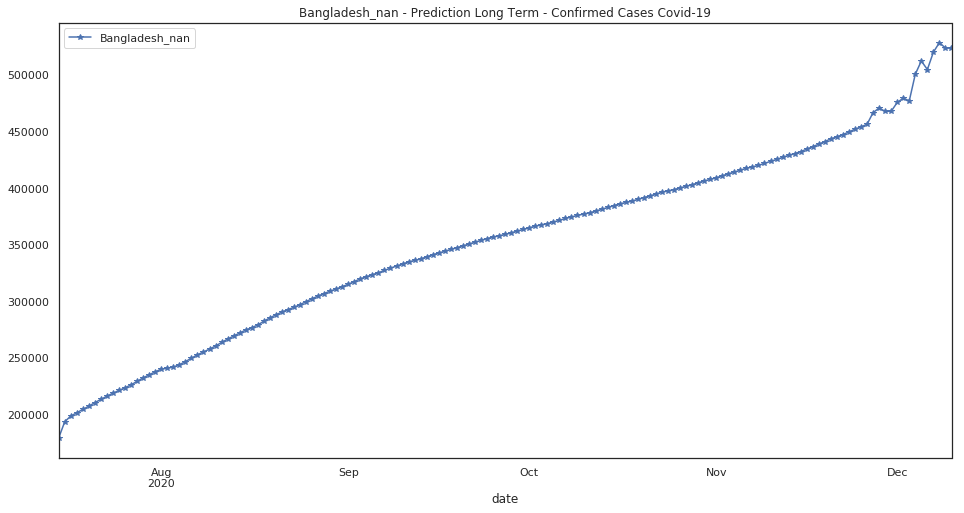

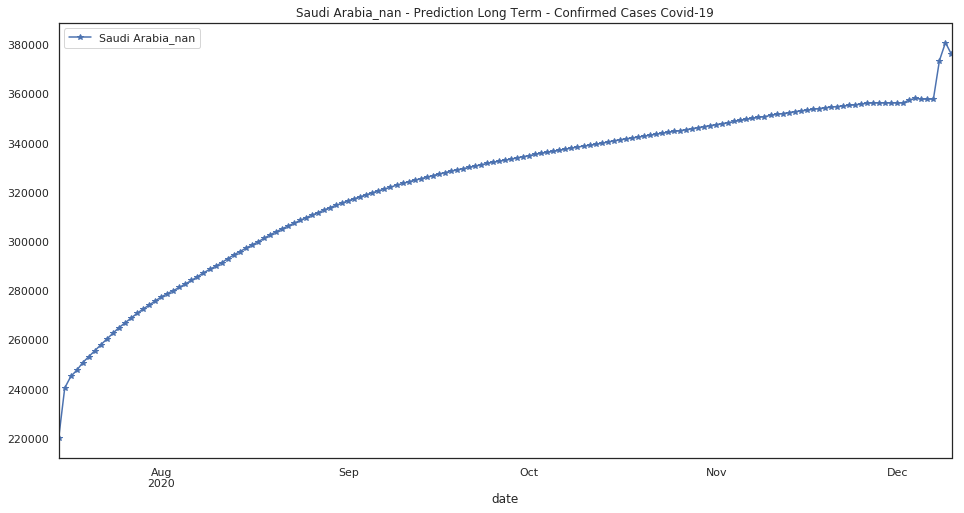

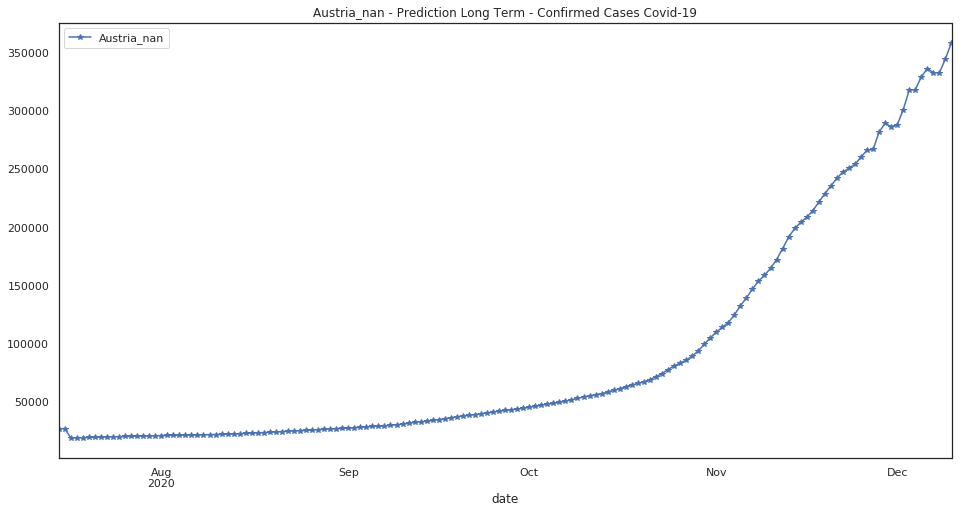

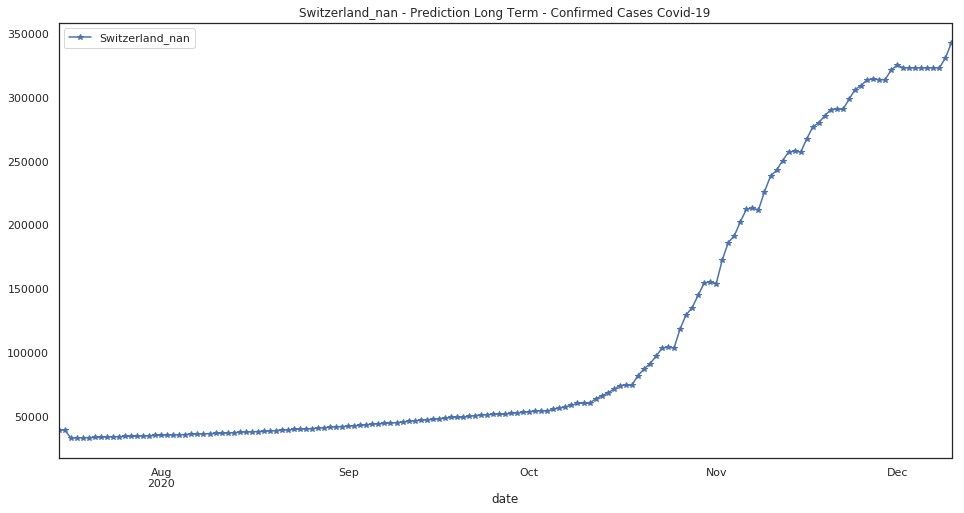

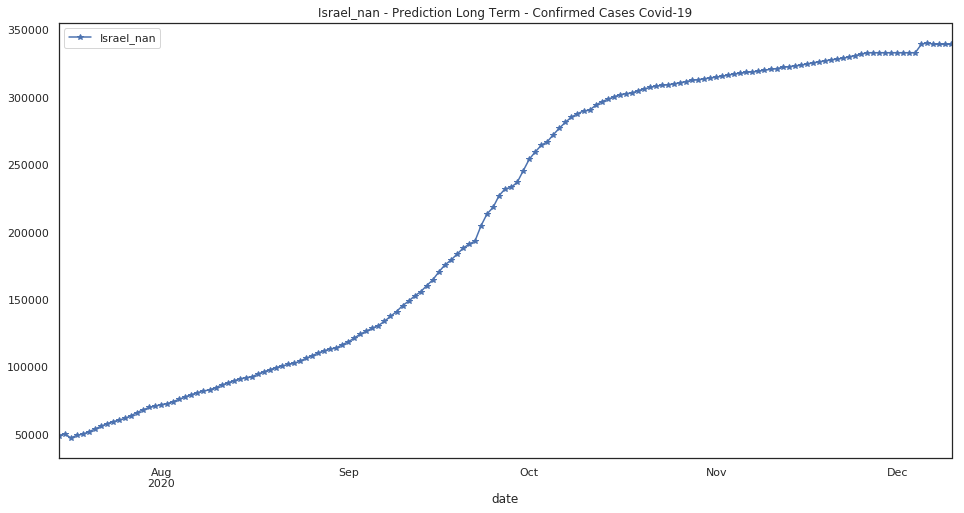

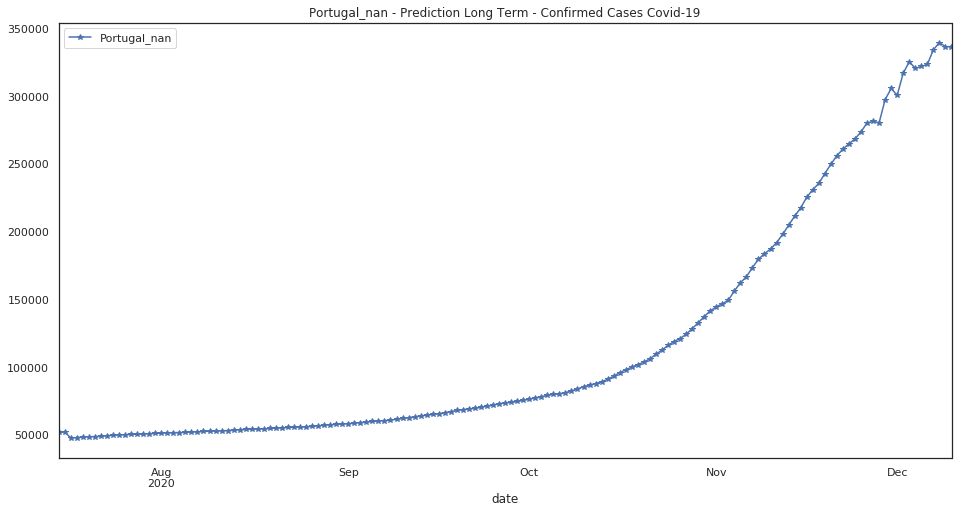

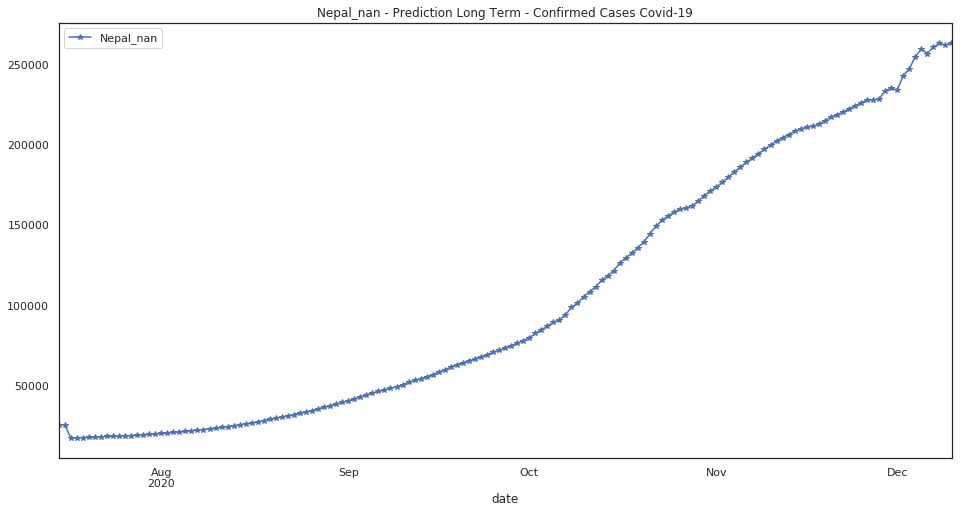

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

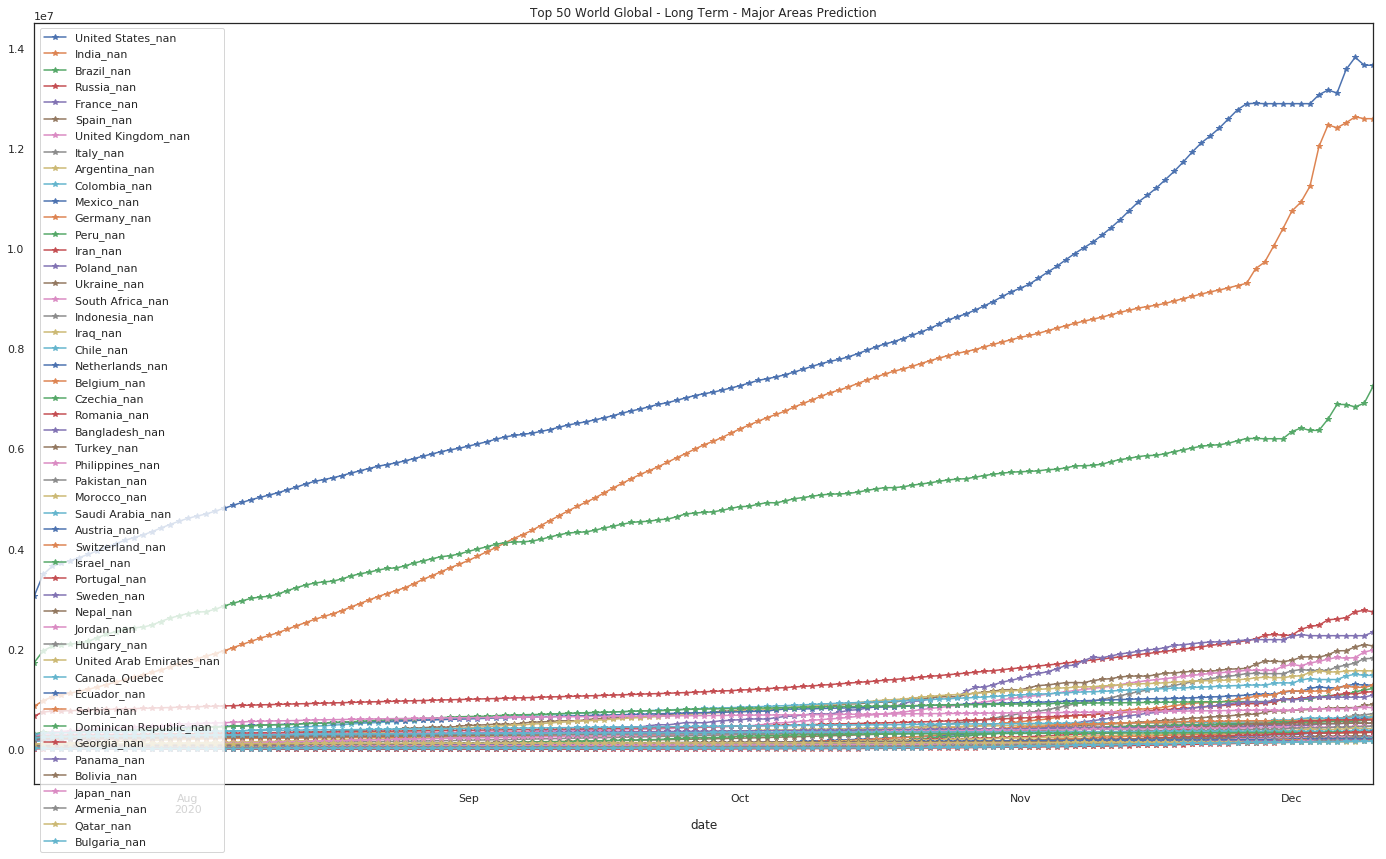

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

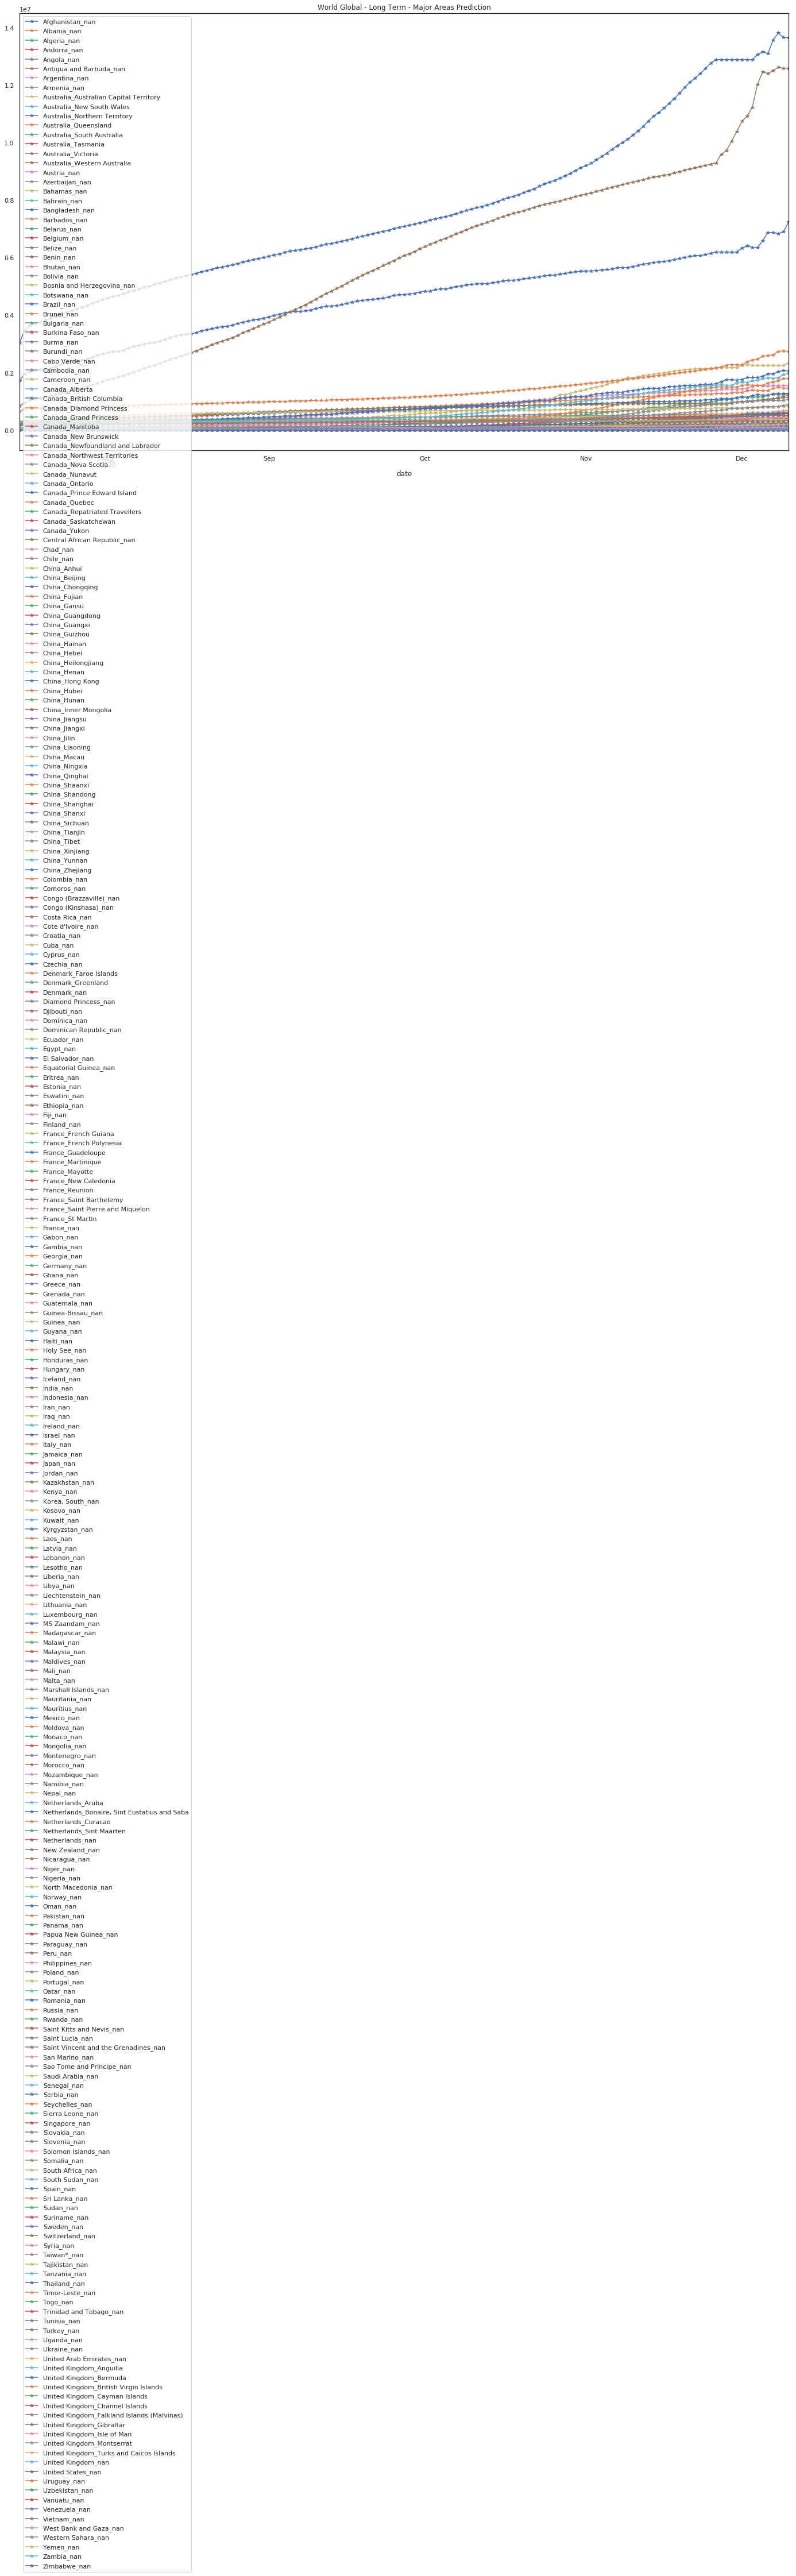

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38241.0       9316.0      43843.0       1124.0   
2020-08-30          38258.0       9433.0      44210.0       1161.0   
2020-08-31          38264.0       9541.0      44559.0       1206.0   
2020-09-01          38291.0       9611.0      44899.0       1176.0   
2020-09-02          38337.0       9764.0      45225.0       1187.0   
2020-09-03          38382.0       9856.0      45538.0       1199.0   
2020-09-04          38402.0       9982.0      45842.0       1243.0   
2020-09-05          38420.0      10113.0      46141.0       1215.0   
2020-09-06          38487.0      10256.0      46434.0       1235.0   
2020-09-07          38583.0      10397.0      46724.0       1275.0   
2020-09-08          38618.0      10549.0      47009.0       1261.0   
2020-09-09          38639.0      10706.0      47288.0       1326.0   
2020-09-10          38667.0      10859.0      47560.0       1301.0   
2020-09-11          38701.0      11018.0      47825.0       1364.0   
2020-09-12          38736.0      11181.0      48081.0       1344.0   
2020-09-13          38805.0      11348.0      48328.0       1371.0   
2020-09-14          38865.0      11514.0      48570.0       1453.0   
2020-09-15          38909.0      11670.0      48809.0       1438.0   
2020-09-16          38949.0      11826.0      49041.0       1532.0   
2020-09-17          38969.0      11964.0      49270.0       1483.0   
2020-09-18          38980.0      12096.0      49490.0       1572.0   
2020-09-19          39012.0      12248.0      49700.0       1564.0   
2020-09-20          39127.0      12389.0      49903.0       1598.0   
2020-09-21          39173.0      12538.0      50101.0       1700.0   
2020-09-22          39191.0      12678.0      50292.0       1681.0   
2020-09-23          39237.0      12811.0      50478.0       1781.0   
2020-09-24          39266.0      12947.0      50658.0       1753.0   
2020-09-25          39282.0      13065.0      50833.0       1833.0   
2020-09-26          39289.0      13180.0      50995.0       1836.0   
2020-09-27          39320.0      13294.0      51147.0       1836.0   
...                     ...          ...          ...          ...   
2020-11-11          42693.0      25729.0      64308.0       5477.0   
2020-11-12          42872.0      26160.0      65160.0       5567.0   
2020-11-13          43050.0      26651.0      66029.0       5616.0   
2020-11-14          43129.0      27168.0      66877.0       5725.0   
2020-11-15          43309.0      27753.0      67730.0       5725.0   
2020-11-16          43486.0      28351.0      68636.0       5872.0   
2020-11-17          43701.0      29035.0      69633.0       5914.0   
2020-11-18          43927.0      29740.0      70680.0       5951.0   
2020-11-19          44284.0      30518.0      71708.0       6018.0   
2020-11-20          44530.0      31348.0      72797.0       6066.0   
2020-11-21          44597.0      32099.0      73839.0       6142.0   
2020-11-22          44771.0      32692.0      74904.0       6207.0   
2020-11-23          45055.0      33462.0      75930.0       6256.0   
2020-11-24          45351.0      34208.0      77033.0       6304.0   
2020-11-25          45571.0      34866.0      78094.0       6351.0   
2020-11-26          45788.0      35521.0      79153.0       6428.0   
2020-11-27          46831.0      35988.0      81422.0       6534.0   
2020-11-28          47051.0      36042.0      85479.0       6669.0   
2020-11-29          46951.0      36040.0      86256.0       6669.0   
2020-11-30          46953.0      37746.0      85569.0       6922.0   
2020-12-01          46963.0      38023.0      88112.0       6922.0   
2020-12-02          47325.0      38047.0      91137.0       6959.0   
2020-12-03          47412.0      38074.0      94577.0       6998.0   
2020-12-04          49369.0      38211.0      96519.0       6998.0   
2020-12-05

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
247                             Timor-Leste_nan  -8.874217  125.727539   
248                                    Togo_nan   8.619500    0.824800   
249                     Trinidad and Tobago_nan  10.691800  -61.222500   
250                                 Tunisia_nan  33.886917    9.537499   
251                                  Turkey_nan  38.963700   35.243300   
252                           United States_nan  40.000000 -100.000000   
253                                  Uganda_nan   1.373333   32.290275   
254                                 Ukraine_nan  48.379400   31.165600   
255                    United Arab Emirates_nan  23.424076   53.847818   
256                     United Kingdom_Anguilla  18.220600  -63.068600   
257                      United Kingdom_Bermuda  32.307800  -64.750500   
258       United Kingdom_British Virgin Islands  18.420700  -64.640000   
259               United Kingdom_Cayman Islands  19.313300  -81.254600   
260              United Kingdom_Channel Islands  49.372300   -2.364400   
261  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
262                    United Kingdom_Gibraltar  36.140800   -5.353600   
263                  United Kingdom_Isle of Man  54.236100   -4.548100   
264                   United Kingdom_Montserrat  16.742498  -62.187366   
265     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
266                          United Kingdom_nan  55.378100   -3.436000   
267                                 Uruguay_nan -32.522800  -55.765800   
268                              Uzbekistan_nan  41.377491   64.585262   
269                                 Vanuatu_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

ValueError: Location values cannot contain NaNs.

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1       7               Armenia_nan  40.069100   45.038200   
2      16               Austria_nan  47.516200   14.550100   
3      20            Bangladesh_nan  23.685000   90.356300   
4      23               Belgium_nan  50.833300    4.469936   
5      27               Bolivia_nan -16.290200  -63.588700   
6      30                Brazil_nan -14.235000  -51.925300   
7      32              Bulgaria_nan  42.733900   25.485800   
8      53             Canada_Quebec  52.939900  -73.549100   
9      59                 Chile_nan -35.675100  -71.543000   
10     93              Colombia_nan   4.570900  -74.297300   
11    102               Czechia_nan  49.817500   15.473000   
12    109    Dominican Republic_nan  18.735700  -70.162700   
13    110               Ecuador_nan  -1.831200  -78.183400   
14    130                France_nan  46.227600    2.213700   
15    133               Georgia_nan  42.315400   43.356900   
16    134               Georgia_nan  42.315400   43.356900   
17    135               Germany_nan  51.165691   10.451526   
18    147               Hungary_nan  47.162500   19.503300   
19    149                 India_nan  20.593684   78.962880   
20    150             Indonesia_nan  -0.789300  113.921300   
21    151                  Iran_nan  32.427908   53.688046   
22    152                  Iraq_nan  33.223191   43.679291   
23    154                Israel_nan  31.046051   34.851612   
24    155                Israel_nan  31.046051   34.851612   
25    156                 Italy_nan  41.871940   12.567380   
26    158                 Japan_nan  36.204824  138.252924   
27    159                Jordan_nan  31.240000   36.510000   
28    186                Mexico_nan  23.634500 -102.552800   
29    191               Morocco_nan  31.791700   -7.092600   
30    194                 Nepal_nan  28.166700   84.250000   
31    199           Netherlands_nan  52.132600    5.291300   
32    207              Pakistan_nan  30.375300   69.345100   
33    208                Panama_nan   8.538000  -80.782100   
34    211                  Peru_nan  -9.190000  -75.015200   
35    212           Philippines_nan  12.879721  121.774017   
36    213                Poland_nan  51.919400   19.145100   
37    214              Portugal_nan  39.399900   -8.224500   
38    215                 Qatar_nan  25.354800   51.183900   
39    216               Romania_nan  45.943200   24.966800   
40    217                Russia_nan  61.524010  105.318756   
41    224          Saudi Arabia_nan  23.885942   45.079162   
42    226                Serbia_nan  44.016500   21.005900   
43    234          South Africa_nan -30.559500   22.937500   
44    236                 Spain_nan  40.463667   -3.749220   
45    240                Sweden_nan  60.128161   18.643501   
46    241           Switzerland_nan  46.818200    8.227500   
47    251                Turkey_nan  38.963700   35.243300   
48    252         United States_nan  40.000000 -100.000000   
49    254               Ukraine_nan  48.379400   31.165600   
50    255  United Arab Emirates_nan  23.424076   53.847818   
51    266        United Kingdom_nan  55.378100   -3.436000   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              107406.0             111146.0             118529.0   
1               39276.0              39759.0              33559.0   
2               27200.0              27301.0              19270.0   
3              179287.0             193590.0             198655.0   
4               65317.0              65636.0              63238.0   
5               56028.0              57717.0              55046.0   
6             1725259.0            1966748.0            2055010.0   
7               17368.0              17601.0               8144.0   
8               60074.0              60198.0              57001.0   
9              290551.0    

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()